In [1]:
import sys
import numpy as np
from numpy import genfromtxt
import tkinter as tk
from tkinter import filedialog
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy import stats
from ipfx import feature_extractor
from ipfx import subthresh_features as subt
from ipfx import feature_vectors as fv
from ipfx.sweep import Sweep
from sklearn.preprocessing import minmax_scale
from pyAPisolation.loadABF import loadABF
import sklearn.preprocessing
import pyabf
import logging
import glob
method='trf'
np.set_printoptions(edgeitems=10)

In [2]:
import autograd.numpy as np
from autograd import grad



In [3]:

def exp_grow(t, a, b, alpha):
    return a - b * np.exp(-alpha * t)

def exp_grow_2p(t, a, b1, alphaFast, b2, alphaSlow):
    return a - b1 * np.exp(-alphaFast * t) + b2*np.exp(-alphaSlow*t) 

In [4]:


f1 = grad(exp_grow_2p)  # 1st derivative of f
f2 = grad(f1) # 2nd derivative of f

def curvature(x, a, b1, alphaFast, b2, alphaSlow):
        return np.abs(f2(x, a, b1, alphaFast, b2, alphaSlow))*(1 + f1(x, a, b1, alphaFast, b2, alphaSlow)**2)**-1.5
    
    
def curvature_real(dy, ddy):
        return abs(dy)*(1 + ddy**2)**-1.5
    
def curvature_splines(x, y=None, error=0.1, smoothing=None):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
         or
         y=None and
         x is a numpy.array(dtype=complex) shape (n_points, )
         In the second case the curve is represented as a np.array
         of complex numbers.
    error : float
        The admisible error when interpolating the splines
    Returns
    -------
    curvature: numpy.array shape (n_points, )
    Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
    but more accurate, especially at the borders.
    """

    # handle list of complex case
    if y is None:
        x, y = x.real, x.imag

    t = np.arange(x.shape[0])
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std), s=smoothing)
    fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std), s=smoothing)

    xˈ = fx.derivative(1)(t)
    xˈˈ = fx.derivative(2)(t)
    yˈ = fy.derivative(1)(t)
    yˈˈ = fy.derivative(2)(t)
    curvature = (xˈ* yˈˈ - yˈ* xˈˈ) / np.power(xˈ** 2 + yˈ** 2, 3 / 2)
    return curvature
    

def derivative(x,y):
    return np.diff(y)/np.diff(x)


def curve_detrend(x,y, curve2):
    test = curvature_splines(x, signal.savgol_filter(y, 51, 1), error=1, smoothing=25)
    cy = np.array([curvature(xi, *curve2) for xi in x])
    #detrend using first and last point
    lin_res = stats.linregress([x[0], x[-1]], [cy[0], cy[-1]])
    trend = x*lin_res.slope + lin_res.intercept
    #plt.plot(x,trend)
    detrended_data = cy - trend
    return detrended_data

In [5]:
def exp_growth_factor(dataT,dataV,dataI, end_index=300):
    #try:
        
        diff_I = np.diff(dataI)
        upwardinfl = np.argmax(diff_I)

        #Compute out -50 ms from threshold
        dt = dataT[1] - dataT[0]
        offset = 0.01/ dt 

        end_index = int(end_index - offset)


        
        upperC = np.amax(dataV[upwardinfl:end_index])
        lowerC  = np.amin(dataV[upwardinfl:end_index])
        diffC = np.abs(lowerC - upperC)
        t1 = dataT[upwardinfl:end_index] - dataT[upwardinfl]
        curve = curve_fit(exp_grow, t1, dataV[upwardinfl:end_index], maxfev=50000, bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))[0]
        curve2 = curve_fit(exp_grow_2p, t1, dataV[upwardinfl:end_index], maxfev=50000,method='trf', bounds=([upperC-5, diffC*0.75, 1e-1,  -diffC*1.25, 0], [upperC+5, diffC*1.25, np.inf,0, np.inf]), xtol=None, gtol=None, ftol=1e-12)[0]
        tau = curve[2]
        tau1 = 1/curve2[2]
        tau2 = 1/curve2[4]
        tau_idx = [2, 4]
        fast = tau_idx[np.argmin([tau1, tau2])]
        slow = tau_idx[np.argmax([tau1, tau2])]
        
        curve_out = curve2# [curve2[0], curve2[fast-1], curve2[fast], curve2[slow-1], curve2[slow]]


        #plt.subplot(1,2,1)
        plt.plot(t1, dataV[upwardinfl:end_index], c='k', alpha=0.5)
        plt.plot(t1, exp_grow_2p(t1, *curve2), label=f'2 phase fit', c='r', alpha=0.5)
        plt.plot(t1, exp_grow(t1, *curve_out[:3]), label=f'Fast phase', c='g', alpha=0.5)
        plt.plot(t1, exp_grow(t1, curve_out[0], *curve_out[3:]), label=f'slow phase', c='b', alpha=0.5)
        plt.title(f" CELL will tau1 {1/curve2[fast]} and tau2 {1/curve2[slow]}")
        #plt.subplot(1,2,2)
        plt.legend()
        #plt.subplot(1,2,2)
        dy = curve_detrend(t1, dataV[upwardinfl:end_index], curve2)
         #signal.savgol_filter(nt1p.diff(dataV[upwardinfl:end_index])/np.diff(t1), 71, 2, mode='mirror')
        #plt.plot(t1,dy)
        
        curve_out = [curve2[0], curve2[fast-1], 1/curve2[fast], curve2[slow-1], 1/curve2[slow]]
        return curve2, np.amax(dy)
    #except:
        return [np.nan, np.nan, np.nan, np.nan, np.nan]

In [6]:
files = glob.glob('C:\\Users\\SMest\\Documents\\clustering-data\\\All IC1s\\*.abf', recursive=True)

In [7]:
cell_type_df = pd.read_csv("C:\\Users\\SMest\\Documents\\clustering-data\\MARM_PVN_IC1\\spike_count_sort_out.csv")
print(cell_type_df.head)
file_names = cell_type_df['filename'].to_numpy()
cell_type_label = cell_type_df['cell_label'].to_numpy()

<bound method NDFrame.head of             filename  label  cell_label  CRH_label  Sag Ratio 001  \
0    2020_01_16_0003      2          -1         -1       0.072335   
1    2020_01_16_0011      1           1         -1       0.053301   
2    2020_01_16_0020      2           3         -1       0.183200   
3    2020_01_16_0025      2          -1         -1       0.200844   
4    2020_01_16_0029      0          -1          0       0.044166   
..               ...    ...         ...        ...            ...   
152         21311038      1           0         -1       0.065753   
153         21311047      1           1         -1       0.069595   
154         21311063      5           1         -1       0.291042   
155         21311074      1          -1         -1       0.123829   
156         21311084      1           1         -1       0.290186   

     Sag Ratio 002  Sag Ratio 003  Sag Ratio 004  Sag Ratio 005  \
0         0.480277       1.081981       1.528664       1.856069   
1      

0
1
[[-39.4946  20.7825  78.9497  -8.2554   6.0949  12.9534  -5.1454]
 [-42.4243  17.6926 157.9195  -8.8669  31.3242   5.0414  -2.5266]
 [-48.1616  13.7329 261.7763  -8.2364  89.2763   2.9322  -1.7586]]
(7,)


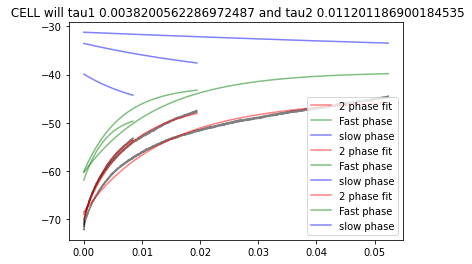

2
[[-43.3093  58.4264  21.1047 -19.7094  21.1047   1.      -0.3373]
 [-46.6663  58.7848  38.0097 -20.7998  38.0097   1.      -0.3538]
 [-49.4434  60.2847  54.1008 -21.3129  54.1008   1.      -0.3535]]
(7,)


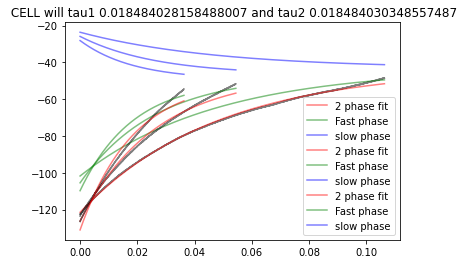

3
[[-47.0325  40.6221  15.2523  -3.7833 113.7031   0.1341  -0.0125]
 [-49.6265  31.3847  30.1996 -12.6711  30.1996   1.      -0.4037]
 [-52.0374  30.0355  45.5715 -11.542   45.5715   1.      -0.3843]]
(7,)


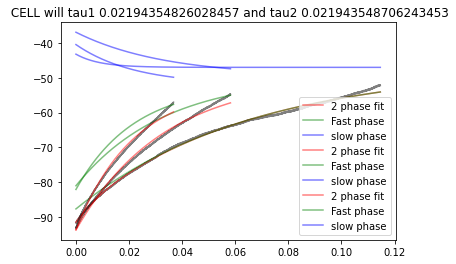

4
[[-38.4166  41.7389  13.7828 -11.5331  13.7828   1.      -0.2763]
 [-36.687   39.9628  19.289  -16.2036  14.8641   1.2977  -0.5262]
 [-36.4734  43.443   23.231  -14.5556  23.231    1.      -0.3351]]
(7,)


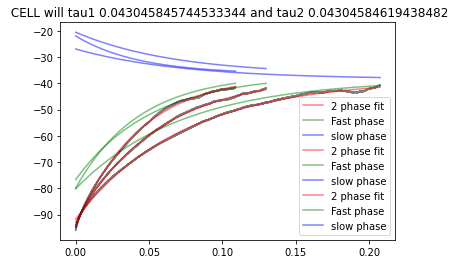

5
6


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: divide by zero encountered in double_scalars
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in double_scalars
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta

[[-3.8187e+01  3.2327e+01  2.5442e+01 -3.4268e+00  3.0854e-30  8.2460e+30
  -8.7411e+29]
 [-4.1287e+01  3.0076e+01  3.9966e+01 -4.9010e+00  3.9966e+01  1.0000e+00
  -1.6296e-01]
 [-4.0762e+01  3.3840e+01  5.3557e+01 -2.4900e+00  5.3557e+01  1.0000e+00
  -7.3581e-02]]
(7,)


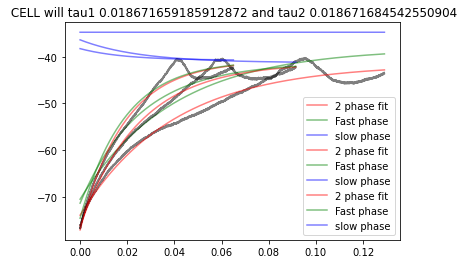

7
8
9
[[-35.2527  21.2402 133.6561 -12.1933  13.0307  10.257   -5.8882]
 [-35.4103  21.286  135.8098 -11.547   27.6377   4.9139  -2.6657]
 [-38.9347  22.905  121.2049  -5.9954 121.203    1.      -0.2618]]
(7,)


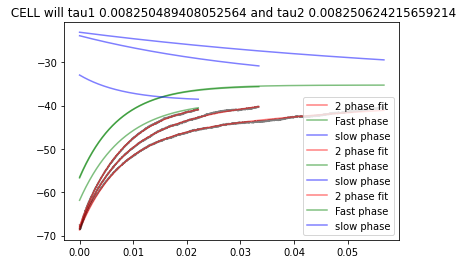

10
[[-32.7808  31.3772  49.2058 -12.3711   9.3156   5.2821  -2.0826]
 [-34.8801  31.5158  47.4613 -10.2198  47.4613   1.      -0.3243]
 [-32.931   32.2963  55.1072 -11.314   55.1071   1.      -0.3503]]
(7,)


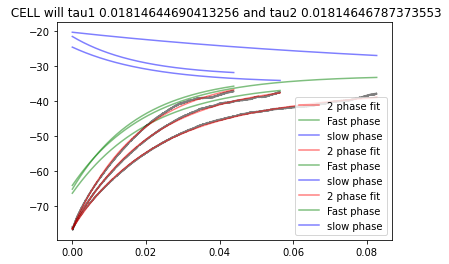

11
[[-36.9617  29.8637  42.7887 -11.1159  42.7887   1.      -0.3722]
 [-39.342   29.0575  64.0447 -10.1424  64.0447   1.      -0.349 ]
 [-43.1873  21.8556 105.1871  -7.5701 105.1871   1.      -0.3464]]
(7,)


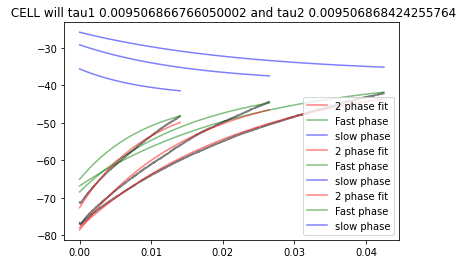

12
13
[[-33.0554  26.5045  80.6742 -14.2529  14.5263   5.5537  -2.9865]
 [-35.0478  29.2442  71.3338  -9.2261  71.3339   1.      -0.3155]
 [-31.2549  30.6622  81.853   -9.1843  81.853    1.      -0.2995]]
(7,)


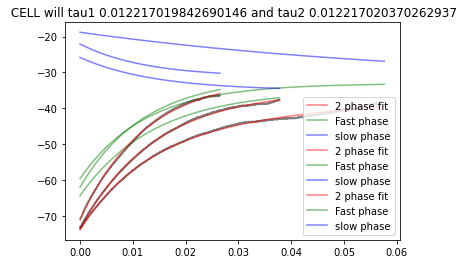

14
[[-28.6914  32.2723  68.162  -19.3632   3.6917  18.4635 -11.078 ]
 [-27.6233  32.4554  70.2422 -17.6043   6.8698  10.2248  -5.5461]
 [-27.4402  33.9485  81.6112 -16.0628   9.2469   8.8258  -4.1759]]
(7,)


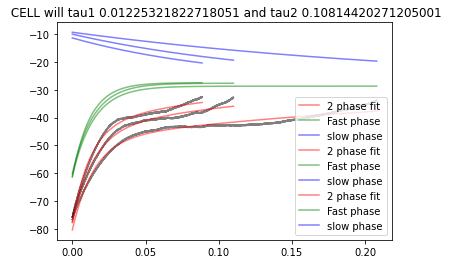

15
[[-32.5671  27.9236 133.9858 -18.4948   5.427   24.6889 -16.3523]
 [-32.2009  26.7563 158.5639 -17.7799   8.7074  18.2102 -12.1009]
 [-33.4216  24.8566 162.1722 -14.8099  13.7606  11.7852  -7.0218]]
(7,)


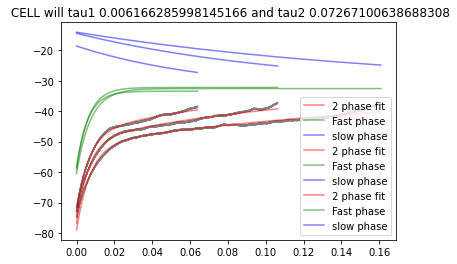

16
17
[[-44.7131  18.2086  64.2021  -6.8241  64.2021   1.      -0.3748]
 [-48.5583  33.4191  46.8492 -12.119   46.8492   1.      -0.3626]
 [-53.6243  30.8816  82.0437 -10.1326  82.0437   1.      -0.3281]]
(7,)


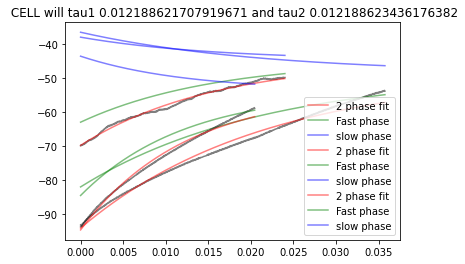

18
[[-45.1404  26.1383  19.7664  -9.5446   1.7667  11.1881  -4.0854]
 [-46.8799  24.7551  28.5989  -8.4042  28.599    1.      -0.3395]
 [-48.2532  25.9055  39.8205  -8.8262  39.8206   1.      -0.3407]]
(7,)


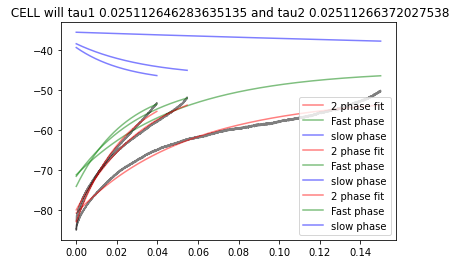

19
[[-34.7339  31.5628  49.2931 -22.6423   2.5684  19.1922 -13.7679]
 [-37.0532  29.7089  24.7424 -11.6648  12.0318   2.0564  -0.8074]
 [-39.1284  30.1888  34.5413 -10.2686  34.5413   1.      -0.3401]]
(7,)


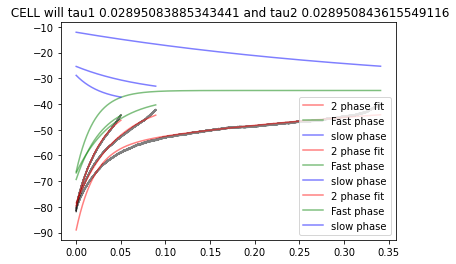

20
[[-46.0559  32.4428  22.23   -11.2328  22.23     1.      -0.3462]
 [-47.7649  31.7282  41.1812 -11.4308  41.1812   1.      -0.3603]
 [-49.4739  31.0942  61.4276 -10.4533  61.4275   1.      -0.3362]]
(7,)


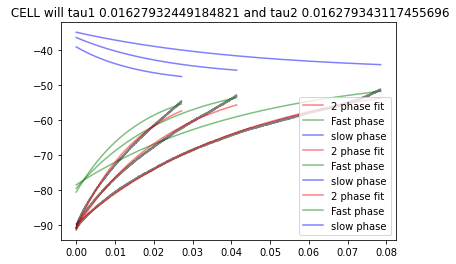

21
[[-39.0979  25.6826  11.515   -8.6821  11.515    1.      -0.3381]
 [-40.4407  24.5895  19.1041  -8.7824  19.1041   1.      -0.3572]
 [-41.2646  23.7609  32.2889  -8.0883  32.289    1.      -0.3404]]
(7,)


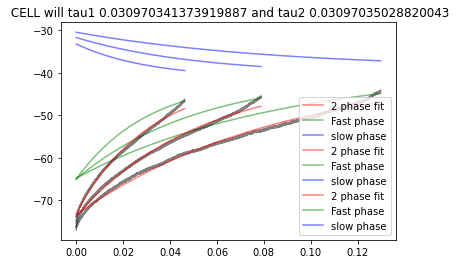

22
[[-52.7393   7.9651 277.6258  -6.476   29.6226   9.3721  -7.62  ]
 [-54.9976   6.0425 590.1176  -6.3725  87.5108   6.7434  -7.1117]
 [-56.2488   6.3858 673.8828  -6.3169 112.5373   5.9881  -5.9235]]
(7,)


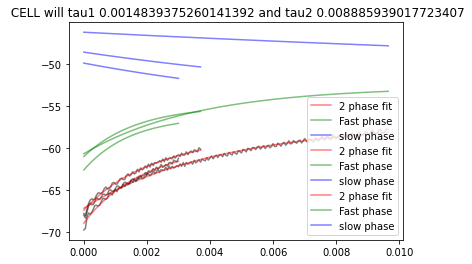

23
[[-31.1328  29.7318  43.9069 -14.291    4.2209  10.4023  -5.    ]
 [-31.8347  29.686   58.2932 -14.2266   8.8978   6.5514  -3.1397]
 [-30.5225  30.9677  67.1428 -14.577   13.1353   5.1116  -2.4061]]
(7,)


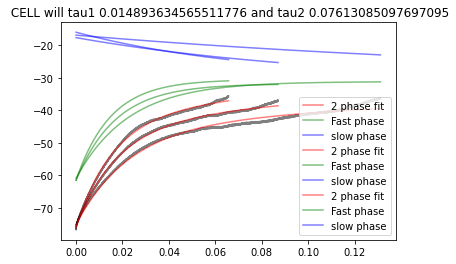

24
[[-36.1798  25.2228 126.5392  -6.7272  31.4316   4.0259  -1.0737]]
(7,)


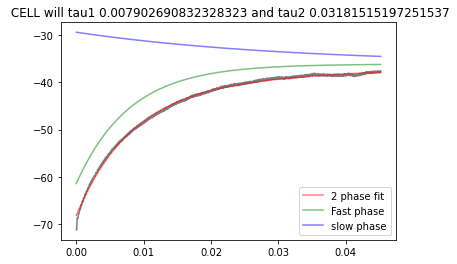

25
[[-33.0554  24.6048  39.9035 -11.4337   7.4382   5.3647  -2.4929]
 [-33.6047  27.6912  43.9273 -10.0019  43.9273   1.      -0.3612]
 [-32.8723  28.0513  63.5005  -9.1595  63.5005   1.      -0.3265]]
(7,)


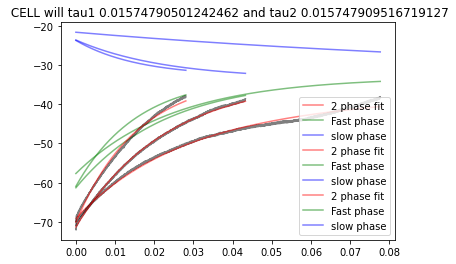

26
[[-32.9028  27.3285  59.3281 -14.2543   4.2787  13.8661  -7.2324]
 [-34.832   27.3514  55.2974 -11.4397  22.3425   2.475   -1.0352]
 [-32.8169  31.2746  52.2536 -10.0547  52.2536   1.      -0.3215]]
(7,)


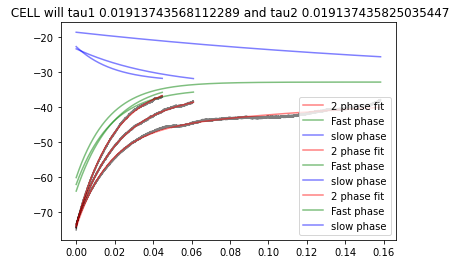

27
[[-31.2244  29.2969 155.9668 -19.3634   6.3201  24.678  -16.3106]
 [-30.8582  29.7089 167.8399 -18.5393   8.6678  19.3636 -12.0835]
 [-30.7666  29.7775 179.4294 -17.8622  11.1924  16.0313  -9.6165]]
(7,)


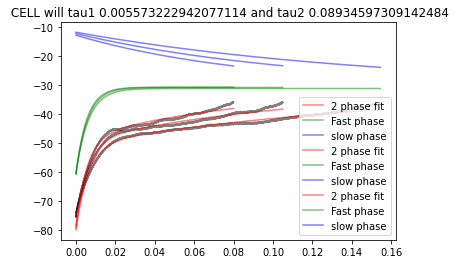

28
[[-32.0483  30.7388  49.9622 -15.5724   6.0341   8.28    -4.1946]
 [-31.1328  31.1508  64.9444 -15.6385  11.8886   5.4628  -2.7424]
 [-36.7456  36.0479  68.5272  -5.04    68.5272   1.      -0.1398]]
(7,)


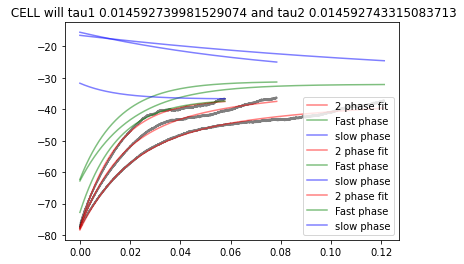

29
[[-35.7104  31.4026  26.4013 -14.2505   6.5237   4.047   -1.8365]
 [-37.8467  32.6144  30.9208 -12.3051  30.9208   1.      -0.3773]
 [-40.6238  32.455   48.0608 -10.0605  48.0608   1.      -0.31  ]]
(7,)


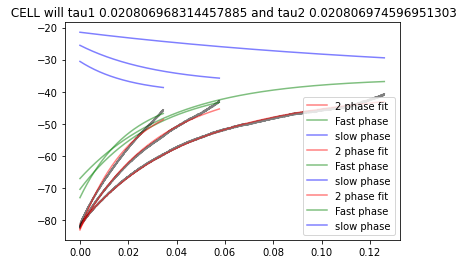

30
[[-32.5671  30.2582  40.0459 -14.5122   3.7206  10.7632  -5.1622]
 [-31.9263  30.6244  46.7797 -14.0993   8.0422   5.8168  -2.678 ]
 [-31.377   37.2584  48.7901  -8.4243   5.6333   8.6611  -1.9583]]
(7,)


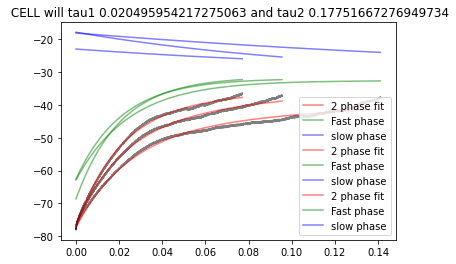

31
[[-31.9263  29.7318   3.2149 -16.809  291.3826   0.011   -0.0062]
 [-31.4075  29.5715 130.4875 -17.6879   2.2431  58.1741 -34.7962]
 [-31.1938  31.2797 137.5073 -16.9004   2.7125  50.6936 -27.3897]]
(7,)


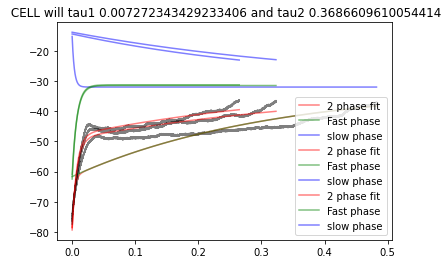

32
[[-31.377   37.5948  42.3853 -17.8371   1.1676  36.3006 -17.2231]
 [-30.2173  41.0113  47.8877 -15.5048   3.627   13.2031  -4.9916]
 [-29.3323  47.133   50.9762 -10.6142   2.2773  22.3844  -5.0409]]
(7,)


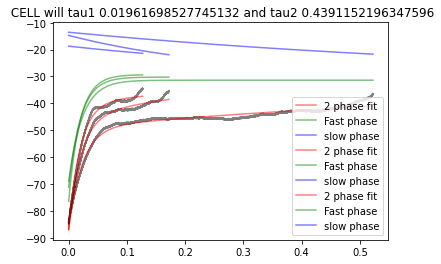

33
34
35
[[-49.1382  35.0962   7.4193 -11.7877   7.4193   1.      -0.3359]
 [-49.5654  34.5196  13.2699 -12.5078  13.2699   1.      -0.3623]
 [-51.0913  35.0787  18.5336 -13.7985  18.5336   1.      -0.3934]]
(7,)


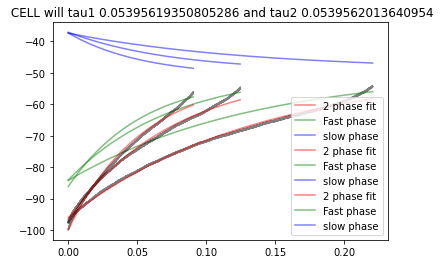

36
37
[[-48.6804  24.8783  18.5763  -9.5484  18.5763   1.      -0.3838]
 [-51.7017  23.8151  32.0123  -8.8745  32.0123   1.      -0.3726]
 [-53.9905  22.1557  46.9805  -8.3418  46.9805   1.      -0.3765]]
(7,)


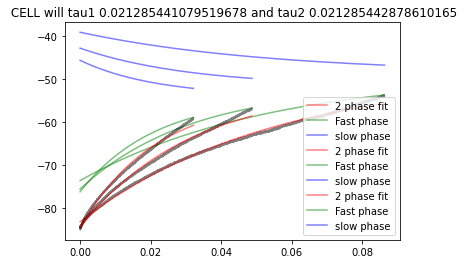

38
fail
39
[[-3.8649e+01  2.6733e+01  2.7424e+00 -5.0808e-07  4.7165e-35  5.8144e+34
  -1.1050e+27]
 [-3.6656e+01  2.7534e+01  1.9004e+01 -1.1290e+01  3.0274e+00  6.2773e+00
  -2.5738e+00]
 [-3.4063e+01  2.9617e+01  1.9112e+01 -1.2069e+01  1.0954e+01  1.7447e+00
  -7.1095e-01]]
(7,)


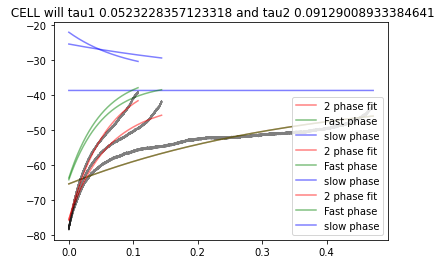

40
[[-4.1021e+01  2.9343e+01  2.3488e+00 -6.4911e-13  6.1148e-09  3.8411e+08
  -8.4972e-06]
 [-4.1265e+01  2.9800e+01  2.9455e+00 -1.5658e-10  7.5309e-15  3.9112e+14
  -2.0550e+03]
 [-4.1326e+01  2.8542e+01  7.9506e+01 -1.9589e+01  2.1255e+00  3.7406e+01
  -2.5673e+01]]
(7,)


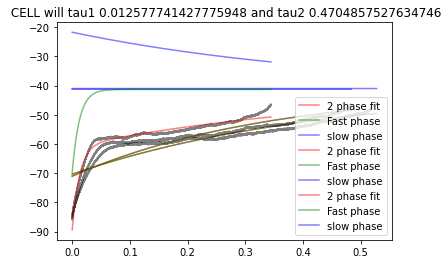

41
[[-42.1802  40.8699  41.2156 -20.4895   1.1585  35.5774 -17.8362]
 [-40.6848  45.0559  55.0853 -18.8904   1.9939  27.6264 -11.5828]
 [-40.6848  48.3815  72.5618 -15.4797   2.413   30.0709  -9.6212]]
(7,)


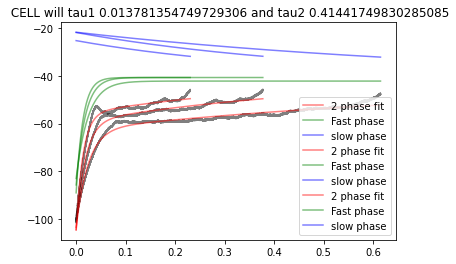

42
[[-44.4995  38.3905  30.7334 -14.0658  30.7334   1.      -0.3664]
 [-47.3987  38.3265  50.3731 -14.1681  50.3731   1.      -0.3697]
 [-51.7017  40.6452  75.0256  -7.7134  75.0256   1.      -0.1898]]
(7,)


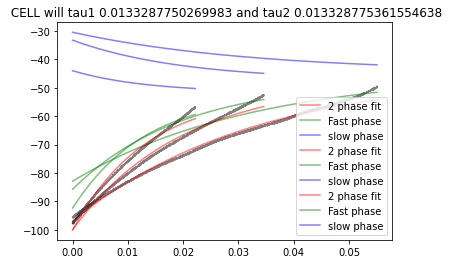

43
[[-40.3186  49.0028  12.6819  -5.147  157.269    0.0806  -0.0085]
 [-42.4548  40.0246  21.0414 -11.9692  21.0413   1.      -0.299 ]
 [-43.1567  40.2341  32.2718 -13.7849  32.2718   1.      -0.3426]]
(7,)


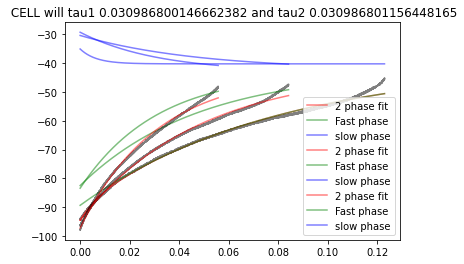

44
[[-36.7175  31.8832  32.6125 -14.9435  14.8273   2.1995  -1.0309]
 [-38.2434  35.1984  41.2195 -12.8743  41.2195   1.      -0.3658]
 [-40.2576  34.2793  57.5401 -12.3386  57.5401   1.      -0.3599]]
(7,)


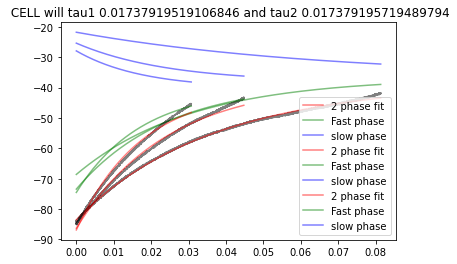

45
46
47
[[-37.8162  36.7126  31.868  -17.4839   2.5039  12.7271  -6.0611]
 [-37.1448  39.1915  43.7852 -14.794    5.29     8.2769  -3.1244]
 [-42.9598  46.1349  45.2827  -3.0086  45.2827   1.      -0.0652]]
(7,)


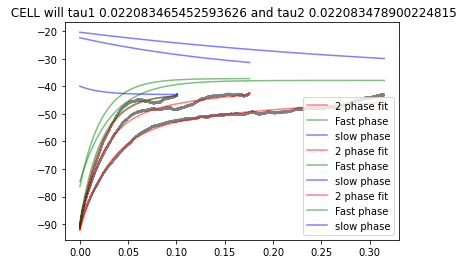

48
[[-30.675   34.1949  20.2898 -14.7204   2.1987   9.2283  -3.9726]
 [-31.1023  33.5999  28.9278 -15.2818  14.4753   1.9984  -0.9089]
 [-30.5835  36.7223  33.3824 -13.3854  33.3824   1.      -0.3645]]
(7,)


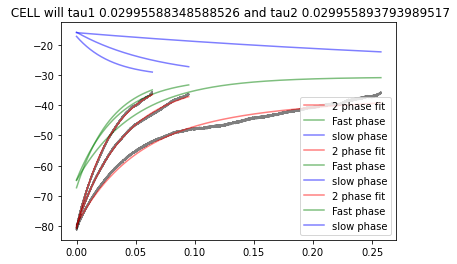

49
[[-32.6892  40.2374  30.6555 -20.0417   2.5773  11.8945  -5.9245]
 [-32.1094  42.1238  33.8878 -15.5714  11.064    3.0629  -1.1322]
 [-33.9509  42.6237  36.3516 -14.9051  36.3516   1.      -0.3497]]
(7,)


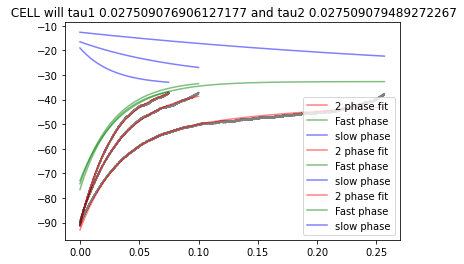

50
[[-33.8184  39.2463  44.9972 -18.3383   1.1693  38.4825 -17.9814]
 [-33.6047  40.8076  57.1265 -15.8733   2.9366  19.4536  -7.567 ]
 [-32.9944  44.0498  69.5846 -13.1654   3.9792  17.4869  -5.2264]]
(7,)


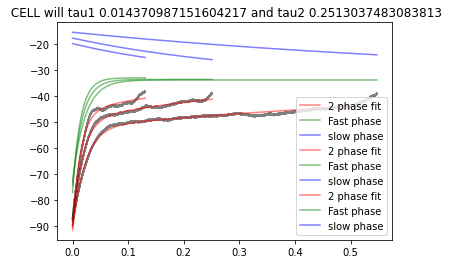

51
[[-36.0156  48.5229  13.7577 -18.9945   4.0169   3.425   -1.3407]
 [-33.208   55.3366  13.3139 -18.3374  13.3139   1.      -0.3314]
 [-32.4756  60.0208  20.466  -21.5667  20.466    1.      -0.3593]]
(7,)


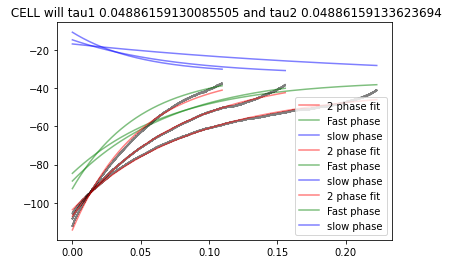

52
[[-39.3962  64.0257  42.0984  -2.8026  42.0984   1.      -0.0438]
 [-36.7735  53.6268  48.0257 -19.0771  48.0257   1.      -0.3557]
 [-34.9321  53.8378  60.2694 -18.3465  60.2694   1.      -0.3408]]
(7,)


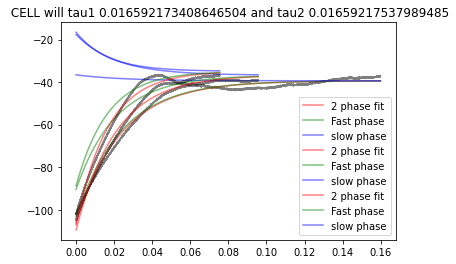

53
[[-31.0718  37.1933  26.8089 -16.0501   9.6632   2.7743  -1.1972]
 [-32.2314  40.0938  31.0862 -14.4073  31.0862   1.      -0.3593]
 [-31.6211  41.8737  41.4341 -14.8635  41.4341   1.      -0.355 ]]
(7,)


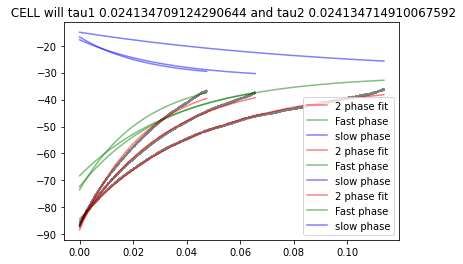

54
55
56
[[-47.1545  57.4493  12.825  -21.8698   2.8346   4.5244  -1.7223]
 [-50.5115  61.9988  18.7287 -23.4371  18.7287   1.      -0.378 ]
 [-52.4951  62.4228  30.6829 -21.8333  30.6829   1.      -0.3498]]
(7,)


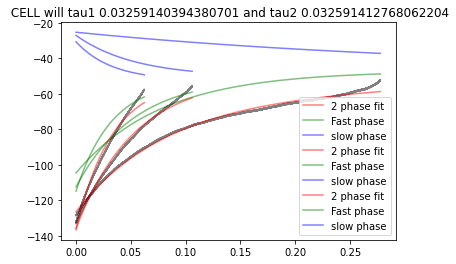

57
[[-43.3704  41.1787  18.0007 -13.6002  18.0007   1.      -0.3303]
 [-45.0488  46.256   31.4237 -11.9987  31.4237   1.      -0.2594]
 [-47.1545  40.0612  48.845  -13.7076  48.8451   1.      -0.3422]]
(7,)


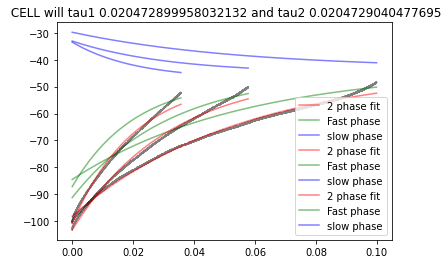

58
[[-30.4919  44.7976  47.6803 -16.5919   7.3565   6.4814  -2.4005]
 [-36.6668  45.7906  54.6379 -10.4917  54.6379   1.      -0.2291]
 [-34.2828  44.9796  69.1681 -12.8394  69.1681   1.      -0.2855]]
(7,)


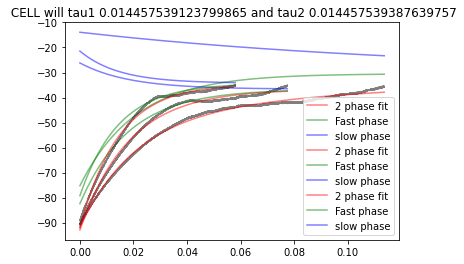

59
[[-29.4849  30.098  100.0263 -17.1388   8.0728  12.3906  -7.0556]
 [-30.8582  31.7423 108.5719 -14.5395   7.8107  13.9004  -6.367 ]
 [-31.4075  33.8496 112.0585 -12.3595   8.8411  12.6748  -4.6279]]
(7,)


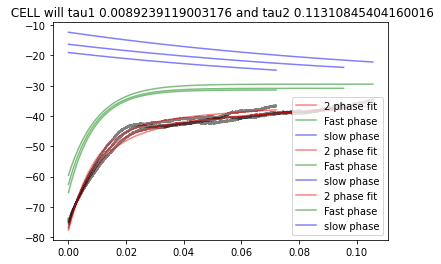

60
[[-39.0979  30.6266  30.3813 -11.1571  30.3813   1.      -0.3643]
 [-42.699   29.6442  50.415  -11.0461  50.415    1.      -0.3726]
 [-47.5208  29.0664  79.7358  -7.8401  79.7358   1.      -0.2697]]
(7,)


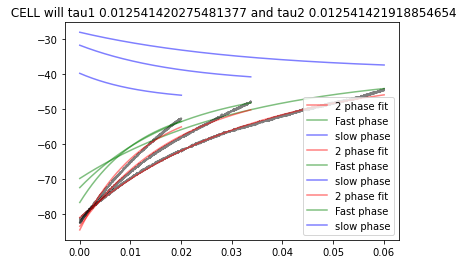

61
[[-34.2761  36.0489  18.1964 -15.1597   6.9125   2.6324  -1.107 ]
 [-34.7644  37.1892  24.6286 -14.7847  24.6286   1.      -0.3976]
 [-34.2151  38.9934  35.233  -14.039   35.233    1.      -0.36  ]]
(7,)


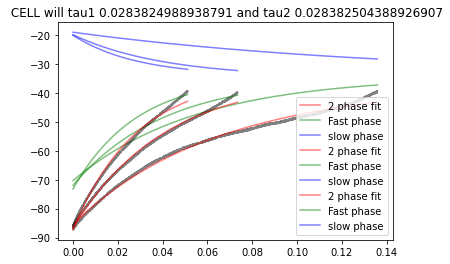

62
63
[[-34.3982  32.7301  36.8136 -17.035    3.4867  10.5584  -5.4953]
 [-34.2761  45.1197  23.9448  -4.2411  95.3732   0.2511  -0.0236]
 [-34.4592  36.6176  40.474  -13.6833  40.474    1.      -0.3737]]
(7,)


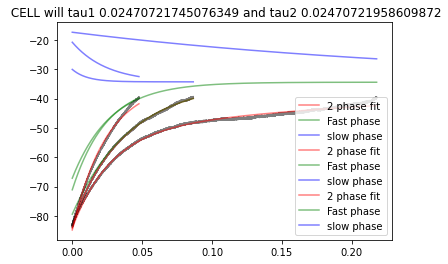

64
[[-28.3862  46.4398  69.7741 -22.0392   2.2765  30.6497 -14.5456]
 [-24.0527  48.3686  80.3522 -24.8848   1.9406  41.4052 -21.3022]
 [-25.3955  49.6526  91.3612 -23.0447   2.3823  38.35   -17.7989]]
(7,)


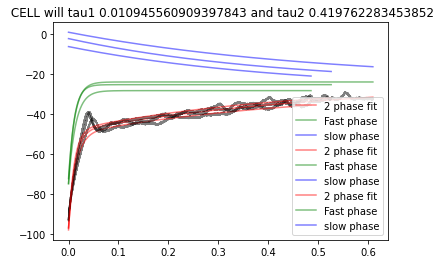

65
[[-35.3137  42.778   15.9323 -14.3302   3.7777   4.2175  -1.4128]
 [-37.9993  41.5184  23.0889 -13.6077  23.0889   1.      -0.3278]
 [-39.5862  42.0642  35.7582 -14.866   35.7582   1.      -0.3534]]
(7,)


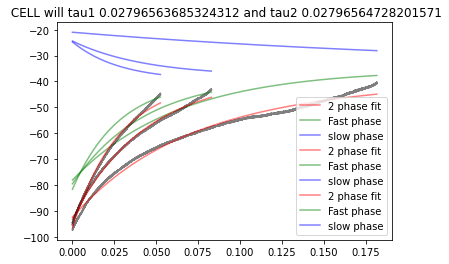

66
[[-36.4734  39.1305  13.142  -13.361   13.142    1.      -0.3414]
 [-37.6636  39.8327  25.8384 -15.5396  25.8384   1.      -0.3901]
 [-40.2881  38.7339  37.6027 -13.8106  37.6027   1.      -0.3566]]
(7,)


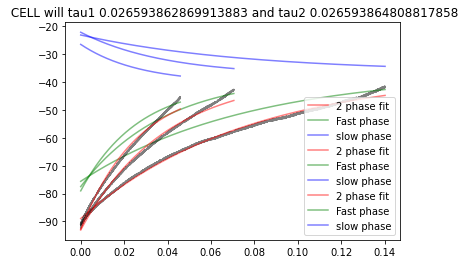

67
[[-34.6118  35.7971  21.3272 -14.4426   7.7227   2.7616  -1.1142]
 [-37.6636  36.4719  27.0317 -13.6106  27.0317   1.      -0.3732]
 [-38.9148  37.6711  35.493  -13.4224  35.4931   1.      -0.3563]]
(7,)


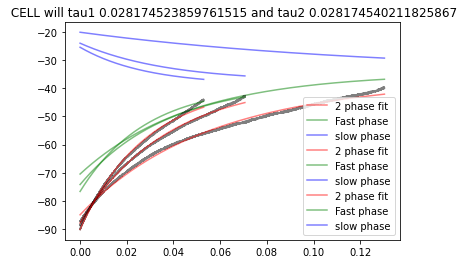

68
69
[[-34.4897  36.3464  28.1411 -17.0394   3.0722   9.16    -4.2943]
 [-34.6423  35.7742  39.0678 -17.4741   5.6584   6.9044  -3.3725]
 [-39.1944  41.2755  37.965   -7.6683  37.965    1.      -0.1858]]
(7,)


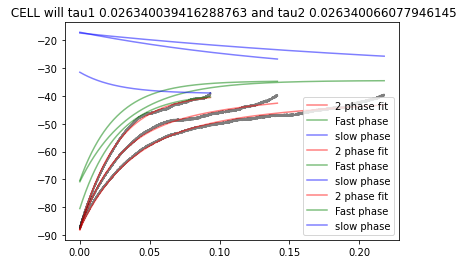

70
[[-37.3279  34.996   17.0077 -15.0433   2.7692   6.1417  -2.64  ]
 [-38.6401  36.9514  21.4248 -13.5434  21.4249   1.      -0.3665]
 [-40.8069  36.4795  33.0249 -13.1248  33.0249   1.      -0.3598]]
(7,)


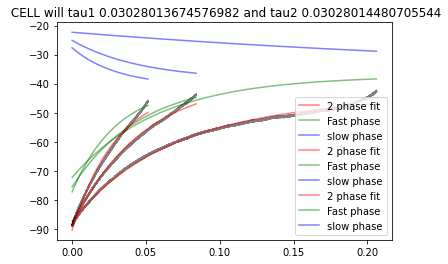

71
72
73
74
75
76
[[-40.5017  34.5154  10.4348 -14.2253   1.1913   8.7588  -3.6099]
 [-40.6848  38.1219  10.4856 -13.0684  10.4856   1.      -0.3428]
 [-41.3867  36.9254  17.9977 -13.6958  17.9977   1.      -0.3709]]
(7,)


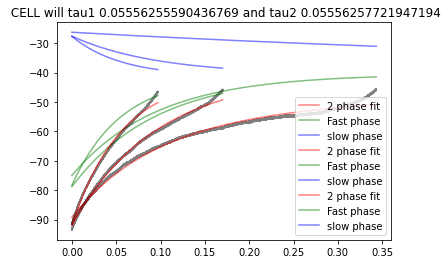

77
[[-49.0161  29.892    4.6469  -8.7386   1.9697   2.3592  -0.6897]
 [-48.9246  30.8568  14.8541 -11.2803  14.8541   1.      -0.3656]
 [-50.6641  35.9194  21.4837 -11.4656  21.4836   1.      -0.3192]]
(7,)


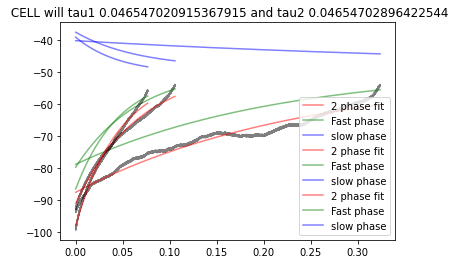

78
[[-42.3938  40.4658  11.3175 -13.9599  11.3175   1.      -0.345 ]
 [-45.4456  39.599   21.0593 -14.9925  21.0593   1.      -0.3786]
 [-48.2227  37.1988  33.5795 -14.766   33.5795   1.      -0.3969]]
(7,)


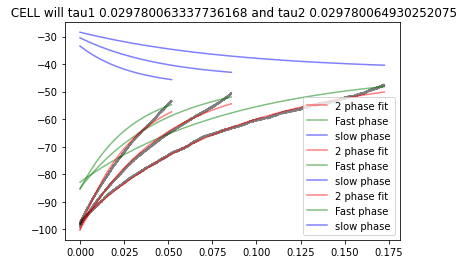

79
[[-40.3186  51.3268  11.3291 -16.742   11.3291   1.      -0.3262]
 [-41.4172  49.7494  20.5005 -17.6155  20.5005   1.      -0.3541]
 [-43.0347  51.2208  31.7538 -18.138   31.7538   1.      -0.3541]]
(7,)


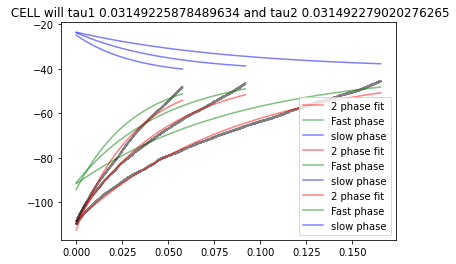

80
[[-48.5583  39.1617   6.8806 -15.0997   1.0506   6.5492  -2.5252]
 [-51.7627  41.5387  13.1839 -15.6033  13.1839   1.      -0.3756]
 [-52.5562  40.2706  21.823  -15.8575  21.823    1.      -0.3938]]
(7,)


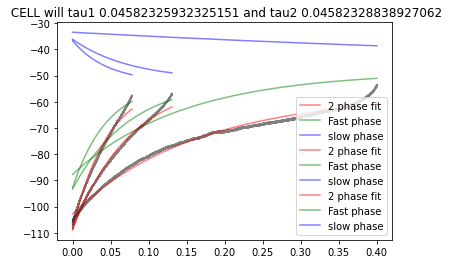

81
[[-26.7993  49.3698  21.2665 -20.9981   8.614    2.4688  -1.05  ]
 [-30.0348  54.2682  25.7352 -16.1718  25.7352   1.      -0.298 ]
 [-31.0911  54.383   33.7086 -14.8814  33.7086   1.      -0.2736]]
(7,)


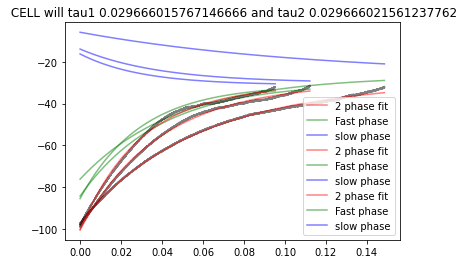

82
fail
83
[[-37.9993  44.0598  13.9353 -15.8852   4.6222   3.0149  -1.087 ]
 [-42.6379  49.6833  19.6423 -15.9521  19.6423   1.      -0.3211]
 [-45.1404  46.8989  30.8642 -18.0252  30.8642   1.      -0.3843]]
(7,)


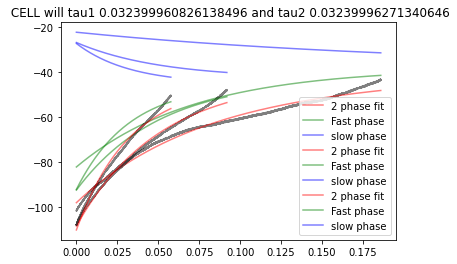

84
[[-37.3279  36.261   29.1916 -12.8063  29.1916   1.      -0.3532]
 [-40.3186  36.4816  48.8819 -12.8986  48.8819   1.      -0.3536]
 [-44.2554  30.7393  83.6741  -9.6707  83.6741   1.      -0.3146]]
(7,)


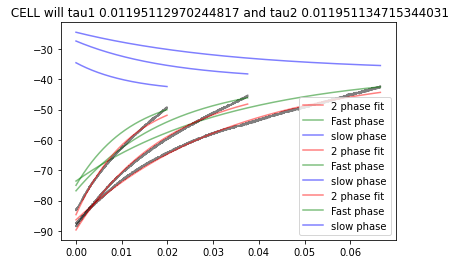

85
[[-45.8728  46.5293  11.4695  -5.7876 154.0745   0.0744  -0.0093]
 [-48.3447  39.4007  21.5901 -12.7939  21.5901   1.      -0.3247]
 [-51.1218  37.1448  33.6966 -13.1171  33.6966   1.      -0.3531]]
(7,)


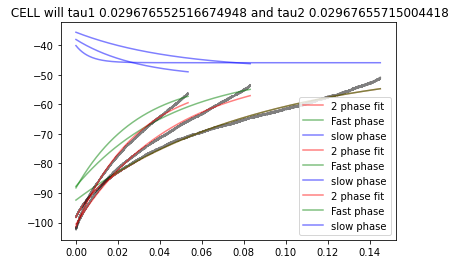

86
87
[[-45.6287  37.1917  13.1391 -12.104   13.1391   1.      -0.3254]
 [-47.7954  36.1907  20.4683 -12.6396  20.4683   1.      -0.3493]
 [-49.5654  33.9419  33.4687 -12.0568  33.4687   1.      -0.3552]]
(7,)


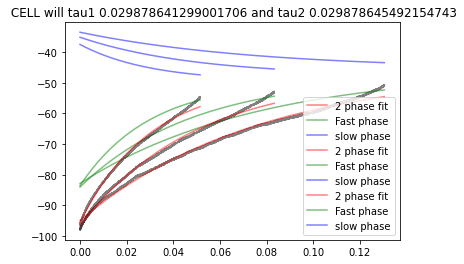

88
[[-44.6216  31.5261   9.185  -11.4302   9.185    1.      -0.3626]
 [-44.4995  28.4739  15.6181 -11.592   15.6181   1.      -0.4071]
 [-45.1099  30.3628  21.7136 -12.0715  21.7136   1.      -0.3976]]
(7,)


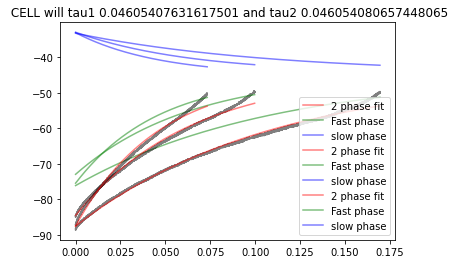

89
[[-48.4668  61.682    9.354   -2.4738  55.9332   0.1672  -0.0067]
 [-50.8167  52.6153  14.7729 -16.6458  14.7729   1.      -0.3164]
 [-52.4646  52.5807  22.0278 -15.7548  22.0278   1.      -0.2996]]
(7,)


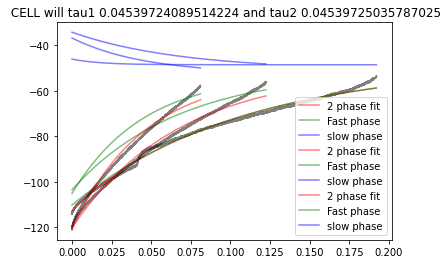

90
[[-38.2434  49.0737  38.8433 -19.8568   2.9369  13.2259  -5.3516]
 [-38.4265  57.0661  48.5881 -14.16     2.267   21.4324  -5.3181]
 [-37.9077  59.4747  58.1329 -11.6444   2.0427  28.4585  -5.5718]]
(7,)


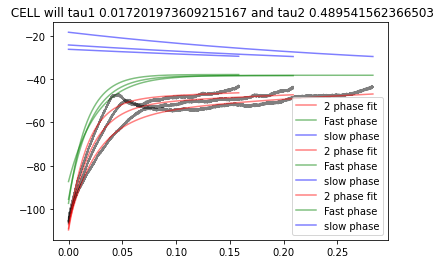

91
[[-45.9033  27.7113  35.7721 -10.1788  35.7721   1.      -0.3673]
 [-48.8025  26.63    48.9386  -9.2042  48.9386   1.      -0.3456]
 [-50.4504  22.641  114.0324  -7.8719 114.0323   1.      -0.3477]]
(7,)


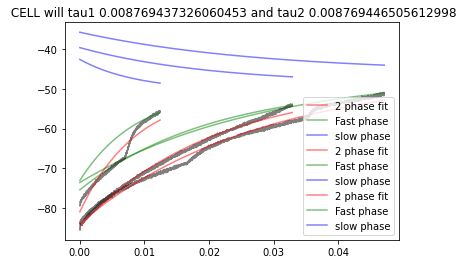

92
[[-51.2744  52.2766  13.981  -22.8996   2.1221   6.5884  -2.886 ]
 [-57.8357  46.3845  20.4665 -16.7327  20.4665   1.      -0.3607]
 [-59.4226  54.314   30.3272 -18.9543  30.3272   1.      -0.349 ]]
(7,)


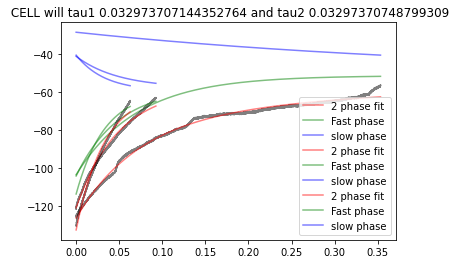

93
[[-38.1824  42.3874  18.2352 -14.5674  18.2352   1.      -0.3437]
 [-38.1519  45.8466  30.6228 -16.2662  30.6228   1.      -0.3548]
 [-40.4407  46.2623  44.462  -16.5865  44.462    1.      -0.3585]]
(7,)


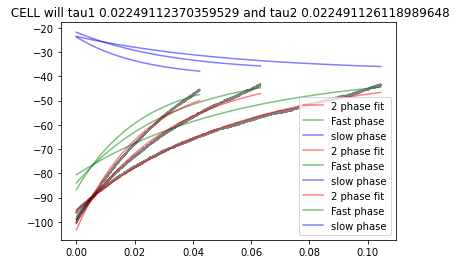

94
[[-30.8582  46.4172  43.0457 -24.598    3.0476  14.1244  -7.485 ]
 [-30.1868  47.7219  48.5271 -23.6676   3.9689  12.2268  -6.0638]
 [-29.79    48.2941  52.4838 -21.7714   4.7048  11.1555  -5.029 ]]
(7,)


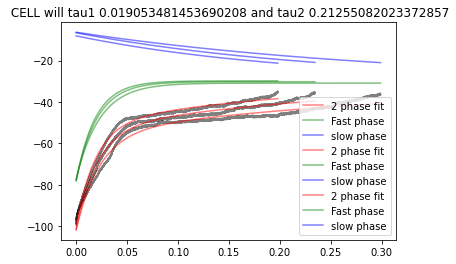

95


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  ratio

[[-46.9409  18.7912  50.7517  -9.744   10.8754   4.6667  -2.4198]
 [-47.0935  17.2577  68.0897  -8.9781  25.743    2.645   -1.376 ]
 [-49.5959  18.1912  84.109   -6.2438  84.109    1.      -0.3432]]
(7,)


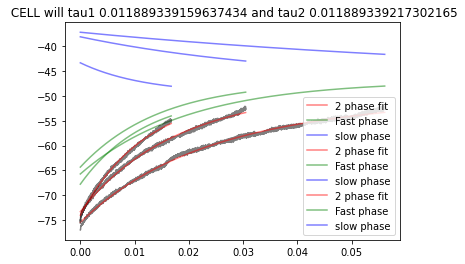

96
[[-50.4199  24.3443  21.376   -8.8236  21.376    1.      -0.3625]
 [-51.8542  24.4427  40.3963  -7.7234  40.3963   1.      -0.316 ]
 [-52.0068  23.0531  56.5318  -7.6299  56.5318   1.      -0.331 ]]
(7,)


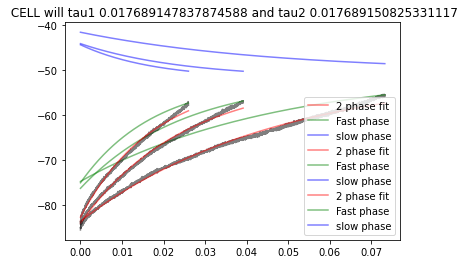

97
[[-46.4832  30.4413  20.1666 -13.5168   6.6462   3.0343  -1.3473]
 [-49.0771  32.353   27.3931 -13.1122  27.3931   1.      -0.4053]
 [-50.9998  29.9772  42.8933 -10.8719  42.8933   1.      -0.3627]]
(7,)


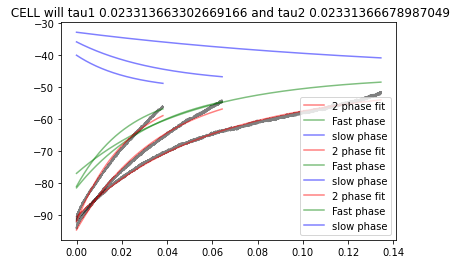

98
99
[[-48.4668  26.7008  34.0848  -9.319   34.0848   1.      -0.349 ]
 [-50.3894  25.7398  56.8249  -8.9432  56.8249   1.      -0.3474]
 [-52.312   24.5588  81.4227  -8.0166  81.4227   1.      -0.3264]]
(7,)


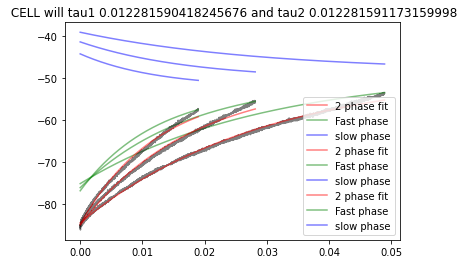

100
[[-33.9404  33.8287  30.5477 -15.2966   4.8598   6.2858  -2.8423]
 [-32.7197  34.9045  34.8406 -15.4748  11.235    3.1011  -1.3748]
 [-33.513   34.4961  36.1811 -11.6592  36.1811   1.      -0.338 ]]
(7,)


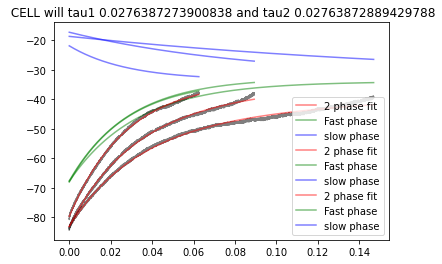

101
[[-33.269   33.1421  43.6583 -14.6099   4.0406  10.805   -4.7631]
 [-35.6494  34.2215  40.6295 -11.1512  40.6295   1.      -0.3259]
 [-38.3655  30.3558  71.4634  -9.0745  71.4634   1.      -0.2989]]
(7,)


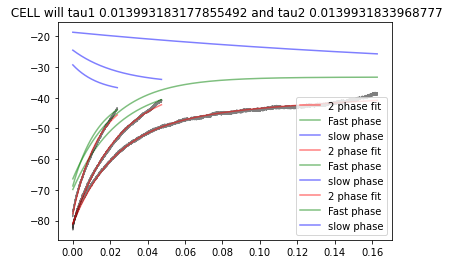

102
103
[[-43.3398  22.7737  44.6159 -11.519   11.4871   3.884   -1.9645]
 [-43.7976  25.2797  53.4512  -9.2463  53.4512   1.      -0.3658]
 [-47.6123  22.3016  84.6254  -7.4237  84.6254   1.      -0.3329]]
(7,)


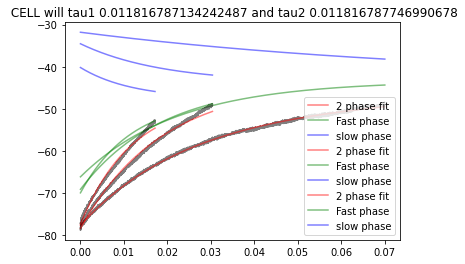

104
fail
105
[[-40.99    36.1136  23.3492  -2.6542 291.0475   0.0802  -0.0059]
 [-42.3938  26.4355  40.6236  -9.5488  40.6236   1.      -0.3612]
 [-43.9502  26.905   56.4993  -7.5458  56.4993   1.      -0.2805]]
(7,)


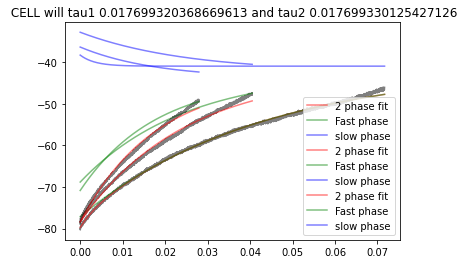

106
[[-32.2009  39.0244  29.2384 -17.642    2.7885  10.4853  -4.7402]
 [-31.5601  38.5208  34.9171 -16.7831   9.4667   3.6884  -1.607 ]
 [-33.6006  40.6991  35.6793 -13.2574  35.6794   1.      -0.3257]]
(7,)


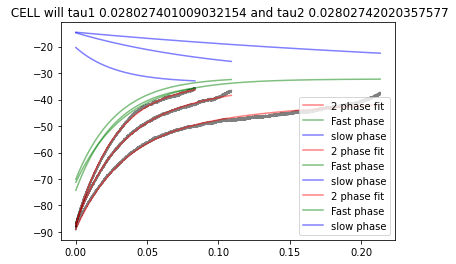

107
[[-33.0859  46.6499  48.9271 -16.8846   2.6565  18.4178  -6.6662]
 [-32.6587  50.8852  55.1024 -14.4784   2.7025  20.3894  -5.8014]
 [-31.5906  54.2128  62.4996 -13.1804   2.9098  21.4787  -5.222 ]]
(7,)


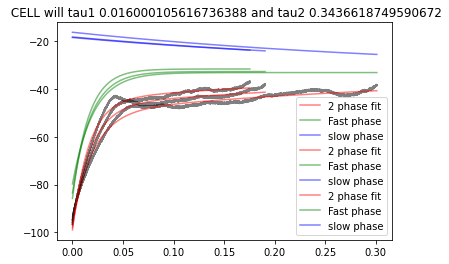

108
[[-40.8069  45.6867  20.2373 -15.7895  20.2373   1.      -0.3456]
 [-42.821   45.4975  34.3552 -15.9889  34.3552   1.      -0.3514]
 [-45.2625  44.026   49.6767 -15.2962  49.6768   1.      -0.3474]]
(7,)


109
110
[[-40.1355  21.5378  48.7974  -9.7044  14.6591   3.3288  -1.4999]
 [-41.2036  22.9956  55.3965  -7.3604  55.3965   1.      -0.3201]
 [-43.8892  21.3726  83.5247  -6.9943  83.5246   1.      -0.3273]]
(7,)


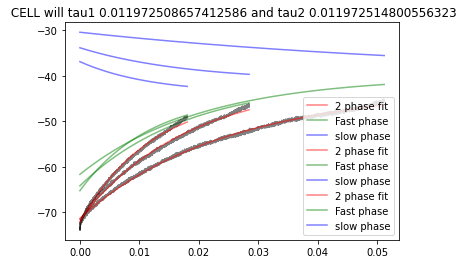

111
[[-48.4668  24.2844  12.3168 -11.7155   2.3394   5.2649  -2.5399]
 [-51.7627  24.071   19.4161 -10.6345  19.4162   1.      -0.4418]
 [-53.4412  23.6643  30.3833 -10.1394  30.3833   1.      -0.4285]]
(7,)


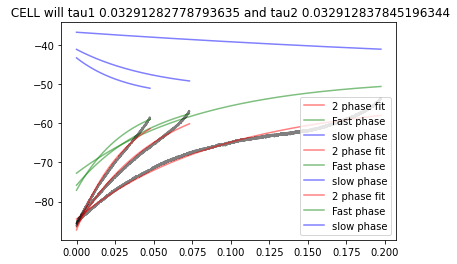

112
113
[[-47.4902  15.5985 141.7342  -6.2803 141.7343   1.      -0.4026]]
(7,)


114
[[-48.772   36.0718   6.1309 -12.2629   0.2608  23.5098  -7.9924]
 [-52.8003  36.372   13.8791 -13.1775  13.8791   1.      -0.3623]
 [-54.2346  34.6266  25.7147 -12.7859  25.7147   1.      -0.3693]]
(7,)


115
[[-49.1382  31.6086  30.7968 -14.1762  20.9598   1.4693  -0.659 ]
 [-52.2815  33.3036  46.672  -12.2305  46.672    1.      -0.3672]
 [-54.4788  33.0365  65.4839 -11.5445  65.4839   1.      -0.3494]]
(7,)


116
fail
117
[[-39.9829  30.7759  18.0076 -10.8858  18.0076   1.      -0.3537]
 [-40.5933  31.1211  32.1649 -11.8418  32.1649   1.      -0.3805]
 [-39.7693  32.4129  44.1489 -11.9092  44.1489   1.      -0.3674]]
(7,)


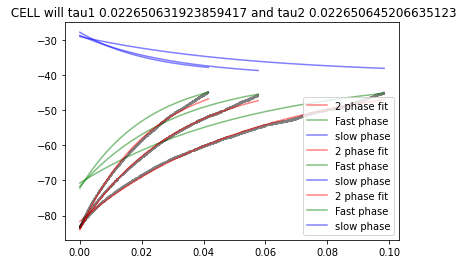

118
[[-41.1731  26.4816  19.2224 -10.7345   2.5      7.6888  -3.1167]
 [-44.0417  26.2771  26.033   -9.4647  26.033    1.      -0.3602]
 [-45.3235  26.4086  45.0972  -9.7449  45.0972   1.      -0.369 ]]
(7,)


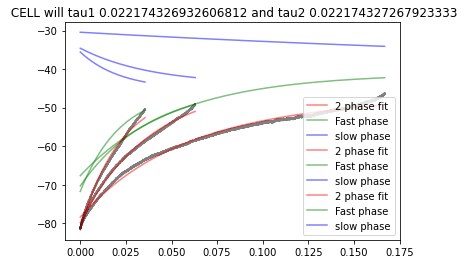

119
[[-53.0444  27.3972  30.5423 -14.8024   3.6789   8.3019  -4.4854]
 [-52.9224  26.3672  28.8016 -12.8168   9.5076   3.0293  -1.4725]
 [-56.1129  28.1902  38.2388  -9.0745  38.2388   1.      -0.3219]]
(7,)


120
[[-41.7834  18.1046  13.1313  -7.2175   5.3651   2.4475  -0.9757]
 [-43.2483  24.4474  25.598   -2.9486 512.4623   0.05    -0.006 ]
 [-45.0183  23.2727  42.0735  -2.4375 801.8412   0.0525  -0.0055]]
(7,)


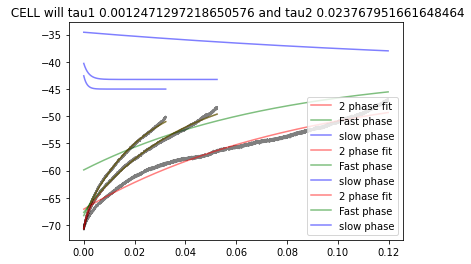

121
[[-38.2434  32.8903  42.9665 -15.8951   5.072    8.4713  -4.094 ]
 [-41.1239  34.4054  42.195  -10.2924  42.195    1.      -0.2992]
 [-37.961   35.6059  57.6693 -12.2995  57.6693   1.      -0.3454]]
(7,)


122
[[-34.2761  52.2537  27.1284 -21.0743   2.6055  10.4121  -4.1993]
 [-42.096   56.4771  41.4958  -2.453   41.4959   1.      -0.0434]
 [-40.8972  61.9912  45.9684  -3.6824  45.9684   1.      -0.0594]]
(7,)


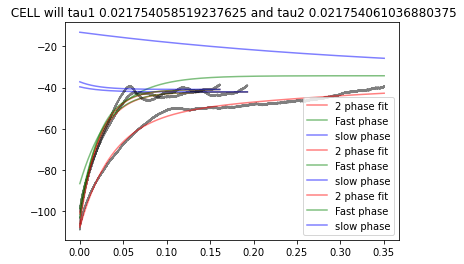

123
[[-45.293   30.1666  18.1687 -12.9501   3.28     5.5393  -2.3779]
 [-49.9927  28.9964  33.6434 -10.7172  33.6434   1.      -0.3696]
 [-51.5186  29.3429  55.5393  -8.6914  55.5393   1.      -0.2962]]
(7,)


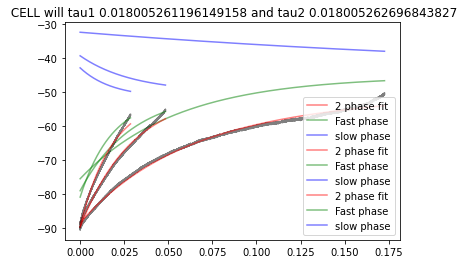

124
[[-37.8772  35.3394  28.2815 -15.2591   5.3929   5.2442  -2.2644]
 [-38.3827  36.621   32.4629 -13.6294  32.4629   1.      -0.3722]
 [-37.2668  39.8511  44.2044 -14.7499  44.2043   1.      -0.3701]]
(7,)


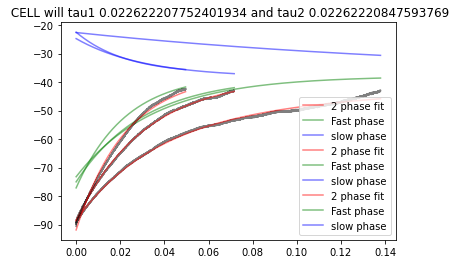

125
126
[[-44.5911  30.2981  13.3007 -10.9713  13.3008   1.      -0.3621]
 [-45.6897  29.3691  23.6532 -11.6454  23.6532   1.      -0.3965]
 [-46.6968  31.0584  35.7354  -9.6809  35.7354   1.      -0.3117]]
(7,)


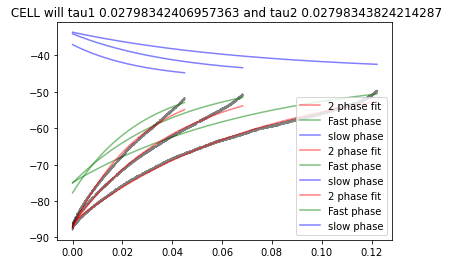

127
[[-39.6854  36.5183  36.0841  -7.0503  36.0841   1.      -0.1931]
 [-38.1448  35.0941  50.9586 -10.3915  50.9586   1.      -0.2961]
 [-36.7678  36.5151  63.2283 -10.4213  63.2283   1.      -0.2854]]
(7,)


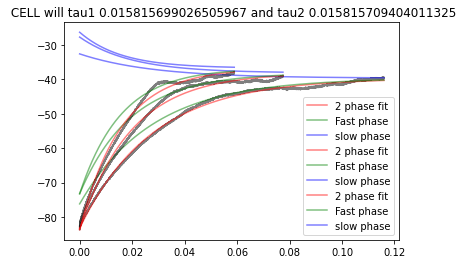

128
[[-31.6211  49.0741  23.478   -2.8905 199.6029   0.1176  -0.0069]
 [-30.5835  39.7033  38.2313 -13.2613  38.2313   1.      -0.334 ]
 [-31.5601  39.9971  53.8024 -12.5107  53.8023   1.      -0.3128]]
(7,)


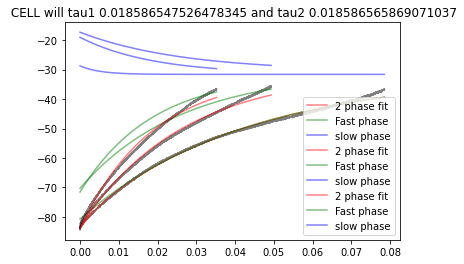

129
130
[[-37.2058  48.3856  16.2627 -19.0567   7.8297   2.0771  -0.8181]
 [-36.5955  51.3762  22.6686 -17.7214  22.6686   1.      -0.3449]
 [-36.9922  50.568   32.5415 -17.6     32.5415   1.      -0.348 ]]
(7,)


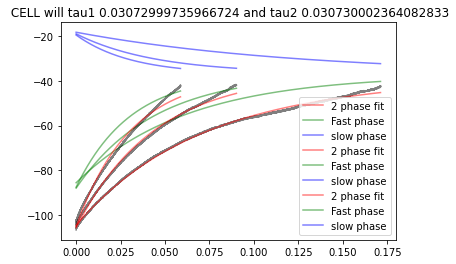

131
[[-32.323   40.057   36.5684 -15.8473   4.4619   8.1956  -3.2423]
 [-31.0718  46.8114  41.1159  -9.7605   3.1132  13.2069  -2.7537]
 [-37.3533  44.2383  48.0232  -7.2012  48.0232   1.      -0.1628]]
(7,)


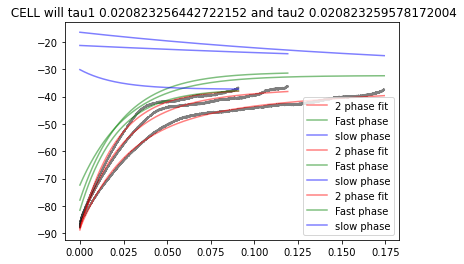

132
fail
133
[[-35.3137  41.2216  32.0115 -17.4397   7.6039   4.2099  -1.7811]
 [-36.8396  44.2076  38.4915 -15.857   38.4915   1.      -0.3587]
 [-40.0134  45.3348  63.509  -12.6224  63.509    1.      -0.2784]]
(7,)


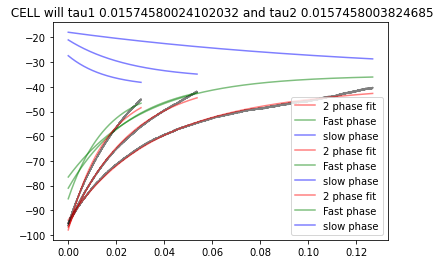

134
135
136
[[-33.6963  29.9149  51.7276 -14.2537  15.6128   3.3131  -1.5786]
 [-33.3911  40.3796  51.0781  -3.4453   4.4363  11.5137  -0.9824]
 [-36.5649  30.5892  73.9874 -10.3363  73.9874   1.      -0.3379]]
(7,)


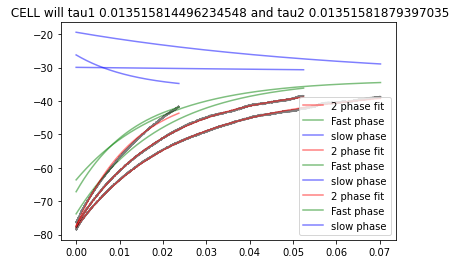

137
[[-30.9802  39.3478  38.6959 -14.2607  38.6959   1.      -0.3624]
 [-27.8369  43.3393  44.2884 -15.4338  44.2884   1.      -0.3561]
 [-26.6467  46.0217  52.8044 -15.6832  52.8044   1.      -0.3408]]
(7,)


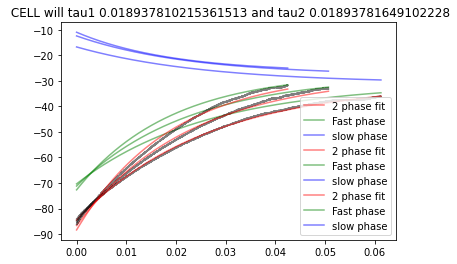

138
139
[[-28.8135  32.4223 114.7463 -16.2869   6.4337  17.8353  -8.9593]
 [-26.9214  33.8483 139.2109 -17.8284   6.2801  22.1672 -11.6758]
 [-24.6936  35.2936 159.5842 -19.5328   8.5672  18.6274 -10.3091]]
(7,)


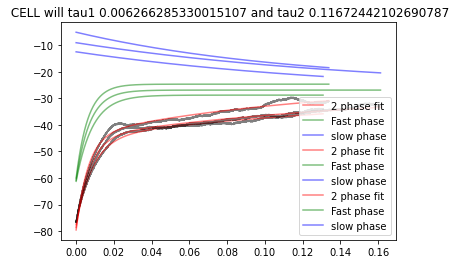

140
141
[[-32.2925  34.3552  38.1152 -15.6127  12.1819   3.1288  -1.4219]
 [-34.6729  36.3675  45.2217 -13.1269  45.2217   1.      -0.361 ]
 [-37.4194  35.9653  69.0588 -11.5388  69.0587   1.      -0.3208]]
(7,)


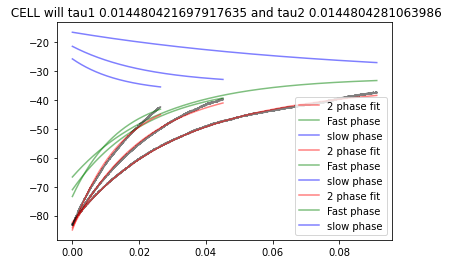

142
[[-33.6047  41.2197  31.9855  -3.3778   6.0854   5.2561  -0.4307]
 [-34.093   33.1875  45.9217 -11.5122  45.9216   1.      -0.3469]
 [-33.208   38.3026  61.0534  -8.7277  61.0534   1.      -0.2279]]
(7,)


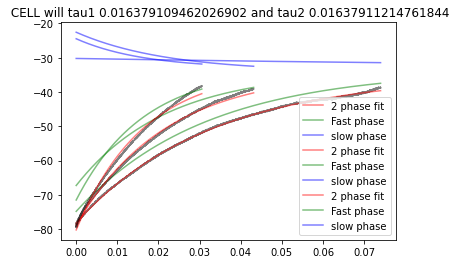

143
144
145
[[-41.5088  35.5911  12.8303 -13.4756   1.9122   6.7096  -2.5404]
 [-43.7061  36.6982  18.2329 -13.0904  18.2329   1.      -0.3567]
 [-45.2625  38.1471  30.3241 -10.4996  30.3241   1.      -0.2752]]
(7,)


146
fail
147
[[-25.6396  37.0331  14.5761 -13.8668   4.6794   3.1149  -1.1664]
 [-30.4309  34.9304  23.3809 -13.2834  23.3809   1.      -0.3803]
 [-33.2385  34.7672  33.1053 -12.3941  33.1053   1.      -0.3565]]
(7,)


148
[[-39.6777  53.2773  19.445  -18.7335  19.445    1.      -0.3516]
 [-42.8516  50.0435  33.4595 -18.5431  33.4595   1.      -0.3705]
 [-46.2695  47.271   52.5545 -14.4613  52.5545   1.      -0.3059]]
(7,)


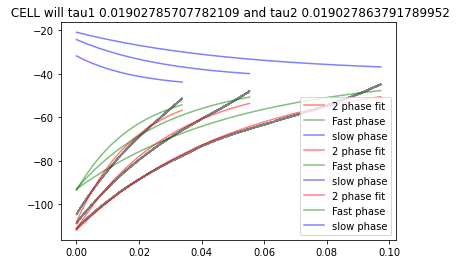

149
[[-45.9644  64.2727  15.8436 -22.5172  15.8436   1.      -0.3503]
 [-46.7883  69.4885  24.1114 -25.6771  24.1114   1.      -0.3695]
 [-54.7229  60.1684  40.5729 -20.3406  40.5729   1.      -0.3381]]
(7,)


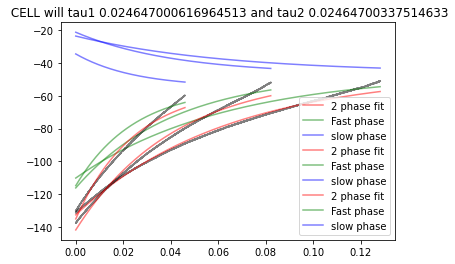

150
[[-41.3257  46.7924  20.6152 -16.479   20.6152   1.      -0.3522]
 [-44.8962  45.7097  33.4749 -16.891   33.4749   1.      -0.3695]
 [-47.2156  43.191   47.044  -15.6252  47.044    1.      -0.3618]]
(7,)


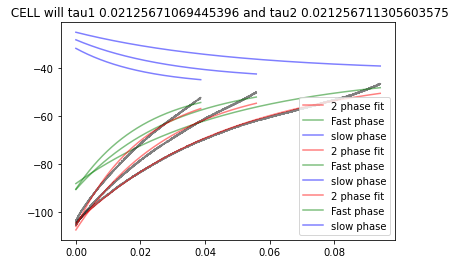

151
fail
152
[[-36.9922  31.0937  16.5527 -10.6167  16.5527   1.      -0.3414]
 [-39.8303  30.2452  30.721  -10.629   30.721    1.      -0.3514]
 [-40.166   27.5918  46.4868 -10.0412  46.4868   1.      -0.3639]]
(7,)


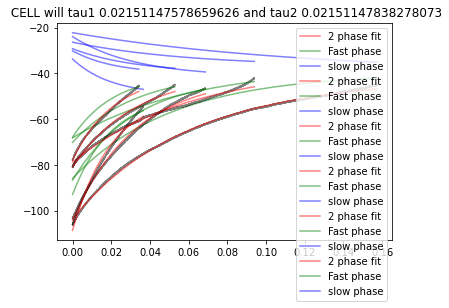

153


C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encountered in double_scalars
  alpha *= Delta / Delta_new
C:\Users\SMest\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_upper = norm(suf) / Delta


[[-42.1802  26.2756  21.6618 -11.9184   6.4173   3.3755  -1.5311]
 [-44.53    25.4934  30.3498  -9.853   30.3497   1.      -0.3865]
 [-46.8494  26.5942  49.4126  -9.6607  49.4126   1.      -0.3633]]
(7,)


154
[[-42.9431  29.5141  23.2814 -11.4996  23.2814   1.      -0.3896]
 [-44.3774  30.4913  37.6002 -11.0399  37.6002   1.      -0.3621]
 [-46.8799  29.8448  57.5351 -10.1959  57.5351   1.      -0.3416]]
(7,)


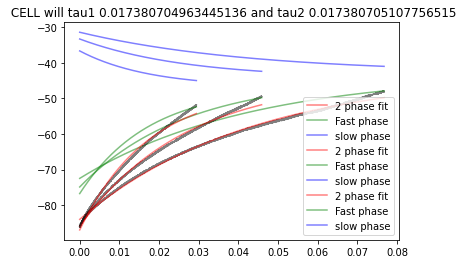

155
[[-37.0532  33.0505  26.6522 -15.3076  11.6518   2.2874  -1.0594]
 [-36.4734  37.3685  35.3123 -14.1365  35.3123   1.      -0.3783]
 [-37.8772  39.2612  51.8799 -11.5101  51.8799   1.      -0.2932]]
(7,)


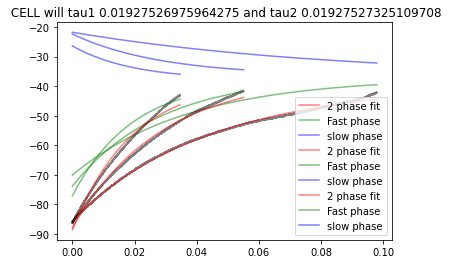

156
157
158
159
160
[[-33.5437  33.3023  33.4058 -14.7998   9.3067   3.5894  -1.5952]
 [-33.0249  32.8217  46.2369 -14.7117   7.8408   5.8969  -2.6432]
 [-35.3209  37.0138  49.1085 -12.6446  49.1085   1.      -0.3416]]
(7,)


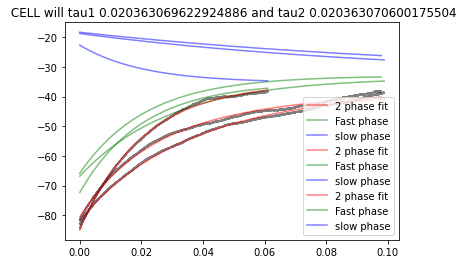

161
[[-36.2598  38.0859  28.8982 -16.9392  11.3357   2.5493  -1.1338]
 [-36.4124  41.5818  39.9908 -15.4375  39.9908   1.      -0.3713]
 [-35.6799  43.1975  55.9016 -14.771   55.9016   1.      -0.3419]]
(7,)


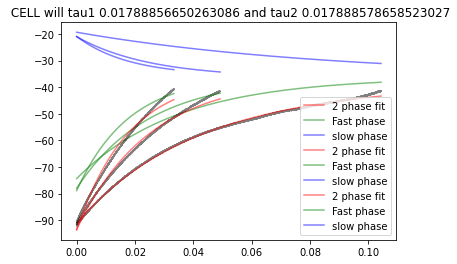

162
fail
163
[[-31.9263  41.6107  25.8012 -29.5666   1.2693  20.3267 -14.4432]
 [-32.8723  40.1917  22.4127 -23.2919   1.5852  14.1387  -8.1937]
 [-31.377   42.3431  22.9793 -22.5918   1.9053  12.0607  -6.4349]]
(7,)


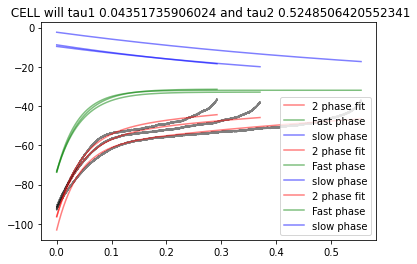

164
fail
165
[[-37.7856  34.1183  25.2954 -13.6278  25.2954   1.      -0.3994]
 [-39.9524  34.7137  40.1684 -13.0002  40.1684   1.      -0.3745]
 [-42.2107  33.0137  57.4153 -11.8282  57.4153   1.      -0.3583]]
(7,)


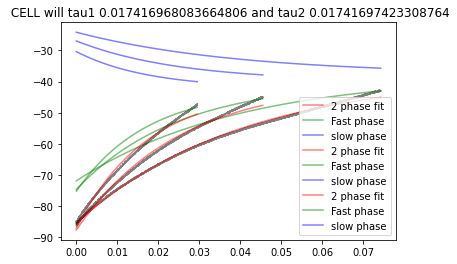

166
[[-33.2996  35.1105  36.4511 -16.1112   6.2501   5.8321  -2.6762]
 [-33.4216  34.1263  47.893  -16.4146  14.5248   3.2973  -1.586 ]
 [-35.3767  37.7999  45.0444 -12.0963  45.0444   1.      -0.32  ]]
(7,)


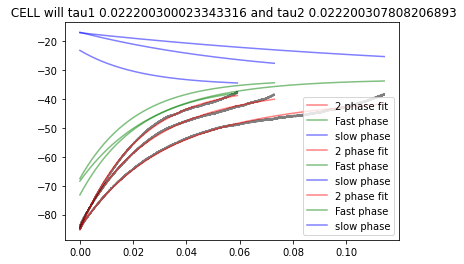

167
[[-30.614   33.5541  60.417  -21.8968   4.0786  14.8132  -9.6668]
 [-30.9497  34.1034  54.3695 -18.002    5.2068  10.4421  -5.512 ]
 [-30.2783  34.8587  64.1011 -17.925    7.9833   8.0294  -4.1289]]
(7,)


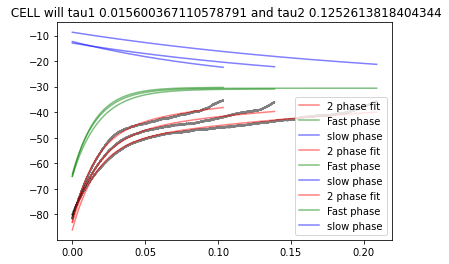

168
[[-31.6211  29.5029  32.1634 -12.9098   7.1579   4.4934  -1.9662]
 [-32.2925  41.1614  33.5729  -2.1682 620.9212   0.0541  -0.0028]
 [-34.917   31.6554  53.9442  -9.2947  53.9442   1.      -0.2936]]
(7,)


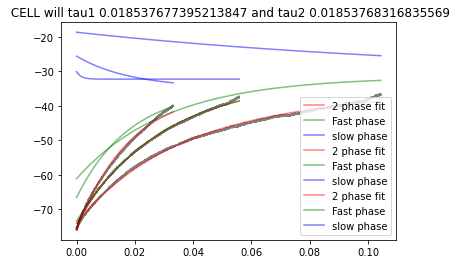

169
170
[[-34.2456  29.5944  58.6327 -14.5222   5.9567   9.8432  -4.8301]
 [-35.863   28.9307  62.3591 -13.6199  17.8649   3.4906  -1.6433]
 [-36.5955  42.7063  50.4581  -1.7761 665.8727   0.0758  -0.0032]]
(7,)


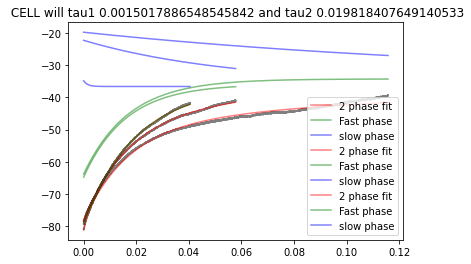

171
[[-30.2478  45.5475  31.5987 -20.857    4.7996   6.5837  -3.0148]
 [-30.9192  45.9667  44.2648 -20.9442   9.3551   4.7316  -2.1559]
 [-37.4283  49.5682  42.5642 -10.5409  42.5642   1.      -0.2127]]
(7,)


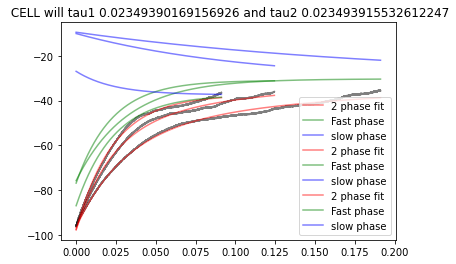

172
[[-34.3677  29.8233  68.89   -14.1928  16.6412   4.1397  -1.9701]
 [-33.269   31.5628  75.3963 -14.7219  25.0868   3.0054  -1.4018]
 [-33.7268  34.3012  70.3533 -11.5291  70.3534   1.      -0.3361]]
(7,)


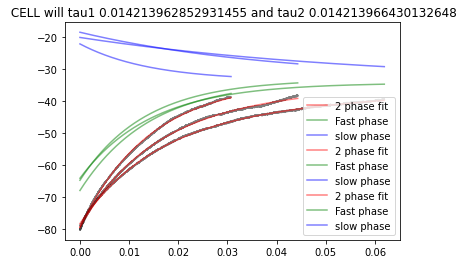

173
[[-32.2925  38.6691  42.3453 -18.7839   2.3435  18.069   -8.7772]
 [-33.3911  41.5668  53.8363 -14.6793   2.3166  23.2398  -8.2071]
 [-45.1099  31.9532  51.8198 -10.729   51.8198   1.      -0.3358]]
(7,)


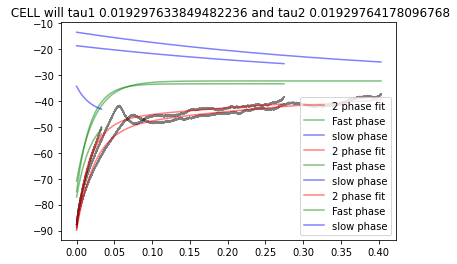

174
[[-28.844   52.2766  81.9979 -29.4116   2.1385  38.3439 -21.5728]
 [-27.6233  55.0436  99.3167 -30.6884   2.6483  37.5014 -20.9081]
 [-27.3792  52.2471 130.3384 -29.5296   2.8556  45.6424 -25.7967]]
(7,)


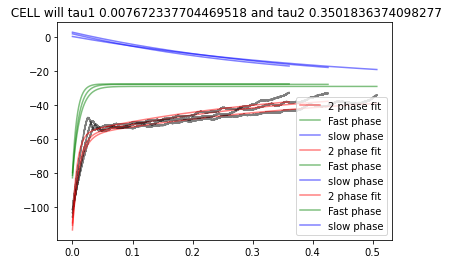

175
[[-35.9407  27.5803  38.1069 -11.9352  61.27     0.622   -0.2691]
 [-34.093   31.8806  57.2375 -10.7608  57.2375   1.      -0.3375]
 [-33.7573  32.7557  74.1979 -10.3327  74.1979   1.      -0.3154]]
(7,)


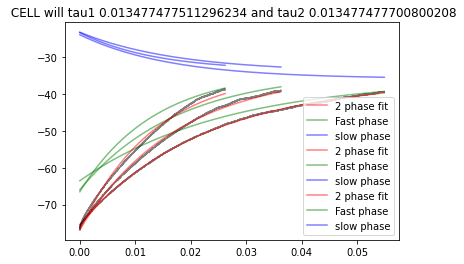

176
[[-36.748   26.9394 100.4448 -13.1643  13.6735   7.346   -3.5897]
 [-35.6494  32.9683  96.1943  -7.422   12.4604   7.72    -1.738 ]
 [-38.9609  31.7139  99.0132  -6.4158  99.0132   1.      -0.2023]]
(7,)


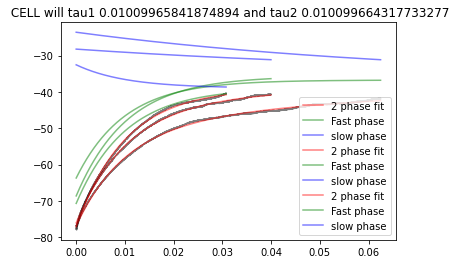

177
[[-34.0625  29.48    48.764  -15.2601   6.119    7.9692  -4.1252]
 [-34.4287  30.9135  38.9618 -11.4788  38.9618   1.      -0.3713]
 [-35.9851  34.1175  58.4763  -8.0056  58.4763   1.      -0.2346]]
(7,)


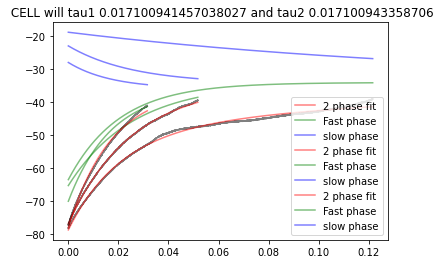

178
[[-52.4036  40.8333 139.5793  -2.1457 139.579    1.      -0.0525]
 [-54.4177  29.2529 172.5224 -10.1816 172.5225   1.      -0.3481]
 [-59.5142  30.5142 209.8274  -5.9537 209.8274   1.      -0.1951]]
(7,)


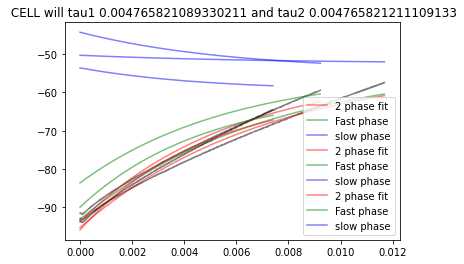

179
180
181
[[-37.9077  58.5577  13.0157  -5.6059 171.4207   0.0759  -0.0073]
 [-39.9219  46.9813  22.2993 -14.9783  22.2992   1.      -0.3188]
 [-41.2036  46.5614  31.5638 -15.5497  31.5638   1.      -0.334 ]]
(7,)


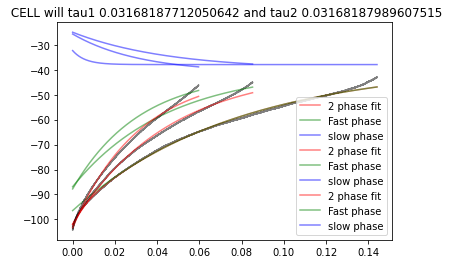

182
183
[[-31.1633  33.0505  49.2427 -15.486    7.5451   6.5265  -3.058 ]
 [-30.7666  31.3797  64.8538 -15.2617  20.392    3.1804  -1.5468]
 [-33.7836  36.717   63.6287 -10.365   63.6287   1.      -0.2823]]
(7,)


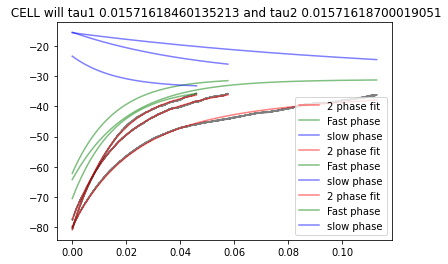

184
[[-50.0232  36.7285  20.7646 -13.5009  20.7646   1.      -0.3676]
 [-52.2815  36.5062  34.1671 -13.0154  34.167    1.      -0.3565]
 [-54.2041  35.7225  48.6573 -12.6395  48.6573   1.      -0.3538]]
(7,)


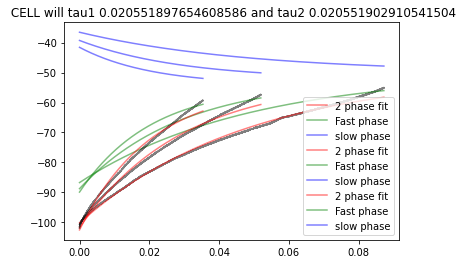

185
186
[[-41.875   36.4199  25.8351 -14.115   25.8351   1.      -0.3876]
 [-45.4761  34.706   48.4608 -12.9281  48.4607   1.      -0.3725]
 [-47.9175  33.3049  72.9256 -11.2514  72.9256   1.      -0.3378]]
(7,)


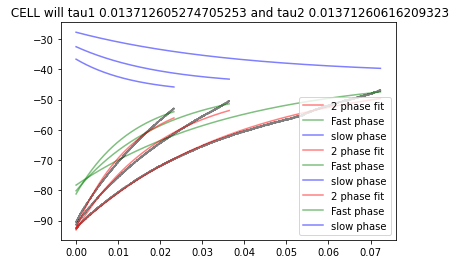

187
[[-37.1753  32.3696  29.3786 -11.6048  29.3786   1.      -0.3585]
 [-38.1519  33.9733  46.1667 -11.2439  46.1667   1.      -0.331 ]
 [-40.5017  32.8305  61.564  -11.9205  61.564    1.      -0.3631]]
(7,)


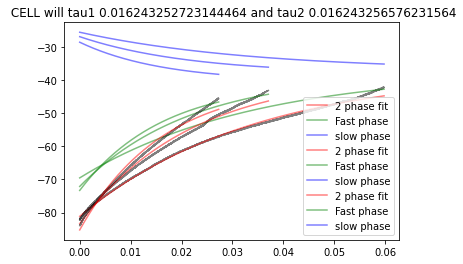

188
189
[[-42.6379  62.457   17.2754 -21.9218  17.2754   1.      -0.351 ]
 [-44.8657  62.3041  29.2937 -23.2252  29.2937   1.      -0.3728]
 [-48.2837  57.3671  46.8397 -20.904   46.8397   1.      -0.3644]]
(7,)


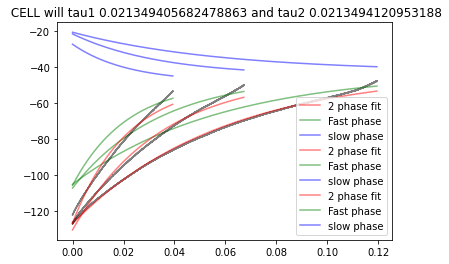

190
191
[[-33.3301  41.4963  24.9389 -15.0832   6.3479   3.9287  -1.428 ]
 [-35.1001  52.6551  26.725  -10.6124  51.3839   0.5201  -0.1048]
 [-34.7034  50.0323  36.8427 -18.1891  36.8427   1.      -0.3635]]
(7,)


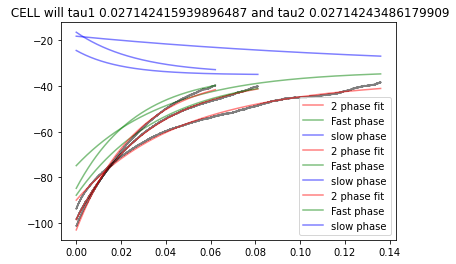

192
[[-30.553   37.5824 160.2307 -33.7733   5.7782  27.7303 -24.9197]
 [-30.4004  43.7851  41.7113 -18.3929   6.7173   6.2095  -2.6084]
 [-30.1257  50.5761  51.4733 -12.482    7.3538   6.9996  -1.7275]]
(7,)


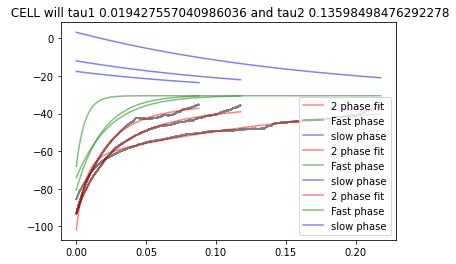

193
[[-54.9365  55.9158  14.7378 -13.6368   3.6671   4.019   -0.9801]
 [-53.4412  61.9975  20.2866 -23.3964  20.2866   1.      -0.3774]
 [-53.197   55.4597  34.3288 -20.76    34.3288   1.      -0.3743]]
(7,)


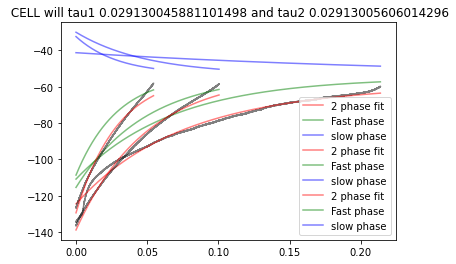

194
[[-33.3301  74.8583  17.0248  -4.4616  82.6129   0.2061  -0.0123]
 [-34.1846  56.7061  33.1608 -21.6407  33.1608   1.      -0.3816]
 [-35.802   55.08    48.4127 -20.0922  48.4127   1.      -0.3648]]
(7,)


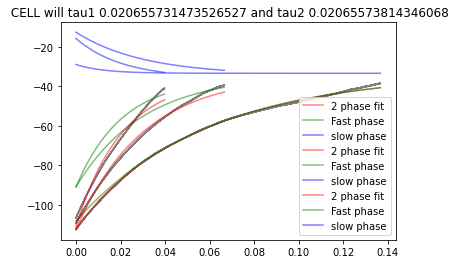

195
196
197
198
[[-35.7104  30.098   18.5164 -11.2169   5.6863   3.2563  -1.2136]
 [-37.5415  38.7184  19.7015  -4.4843 364.5326   0.054   -0.0063]
 [-39.0674  29.3838  30.7952  -9.8214  30.7952   1.      -0.3342]]
(7,)


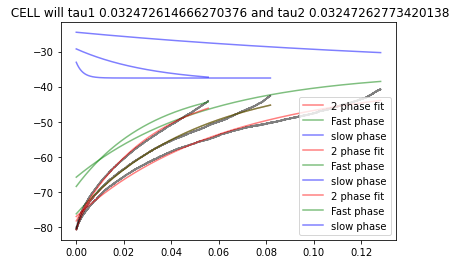

199
200
201
[[-38.5207  45.0168  29.4362  -9.9475  29.4362   1.      -0.221 ]
 [-39.1524  40.3897  49.3241 -11.858   49.3241   1.      -0.2936]
 [-37.4499  49.1025  50.4887 -16.4185  50.4886   1.      -0.3344]]
(7,)


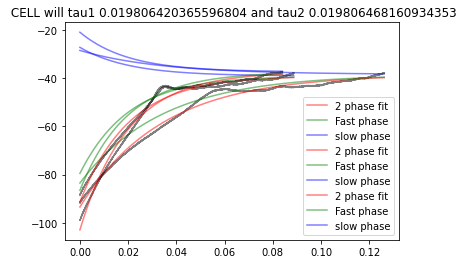

202
[[-36.0767  59.6284  11.8129  -3.1832  84.3784   0.14    -0.0075]
 [-39.6167  45.4354  23.1982 -16.6307  23.1982   1.      -0.366 ]
 [-41.936   44.7907  35.3241 -16.9895  35.3241   1.      -0.3793]]
(7,)


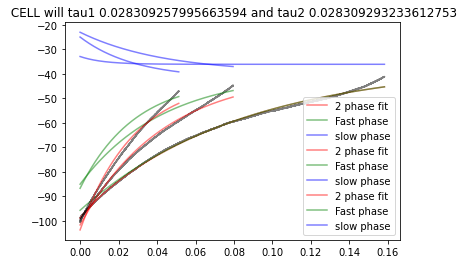

203
204
[[-36.5039  27.1912  48.2482 -13.1325  23.9119   2.0177  -0.9745]
 [-40.2881  29.9117  63.3466 -10.8067  63.3466   1.      -0.3613]
 [-44.1638  26.7509  98.9038  -9.6746  98.9038   1.      -0.3617]]
(7,)


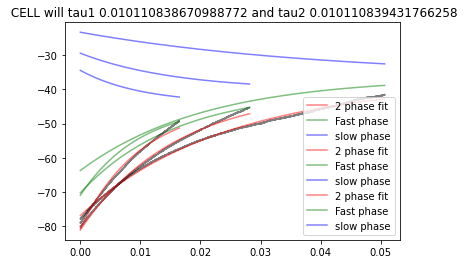

205
[[-29.4849  58.1982  16.4987 -20.7162  16.4987   1.      -0.356 ]
 [-28.783   60.4009  28.1051 -22.5049  28.1051   1.      -0.3726]
 [-28.9661  61.4187  39.3164 -23.0617  39.3164   1.      -0.3755]]
(7,)


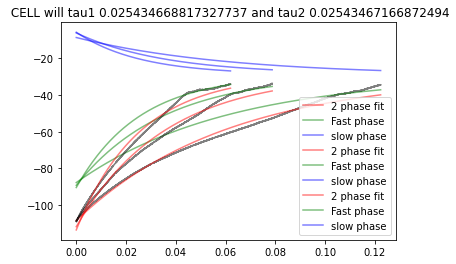

206
[[-46.0864  34.7672  19.9013 -14.5963   5.775    3.4461  -1.4468]
 [-45.4456  37.6306  26.0154 -14.5474  26.0154   1.      -0.3866]
 [-45.1099  39.8484  35.9826 -14.6671  35.9826   1.      -0.3681]]
(7,)


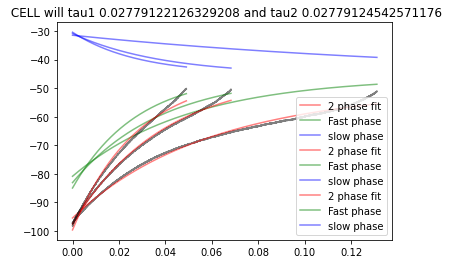

In [8]:
curves = []
label = []
ids = []
max_curve = []
for i, f in enumerate(files[:]):
    print(i)
    try:
        base = os.path.basename(f)
        base = base.split(".")[0]
        if base in file_names:
            x, y, c = loadABF(f)
            
            temp_curves =[]
            #plt.clf()
            iterd = 0
            for sweepX, sweepY, sweepC in zip(x,y,c):
                spikext = feature_extractor.SpikeFeatureExtractor(filter=0, end=1.25)
                res = spikext.process(sweepX, sweepY, sweepC)
                if res.empty==False and iterd < 3:
                    iterd += 1
                    spike_time = res['threshold_index'].to_numpy()[0]
                    #plt.figure(num=2)
                    curve, max_dy = exp_growth_factor(sweepX, sweepY, sweepC, spike_time)
                    max_curve.append(max_dy)
                    temp_curves.append(curve)
            temp_curves = np.vstack(temp_curves)
            div = np.ravel((temp_curves[:,2]) / (temp_curves[:,4])).reshape(-1,1)
            
            sum_height= (temp_curves[:,1] + temp_curves[:,3])
            ratio = (temp_curves[:,2] / (temp_curves[:,1] / sum_height)) / (temp_curves[:,4] / (temp_curves[:,3] / sum_height))
            ratio = np.ravel(ratio).reshape(-1,1)
            temp_curves = np.hstack([temp_curves, div, ratio])
            print(temp_curves)
            meanC = np.nanmean(temp_curves, axis=0)
            print(meanC.shape)
            curves.append(meanC)
            label_idx = np.argwhere(file_names==base)
            

            label.append(cell_type_label[label_idx])
            
            ids.append(base)
            plt.savefig(f+".png")
            plt.show()
            
            plt.close()
    except:
        print("fail")
curves = np.vstack(curves)

In [9]:
#lab = sklearn.preprocessing.LabelEncoder()
#int_lab = lab.fit_transform(label)
print(curves)
label = np.ravel(label).reshape(-1,1)
div = np.ravel((curves[:,2]) / (curves[:,4])).reshape(-1,1)
print(div)
sum_height= (curves[:,1] + curves[:,3])
ratio = (curves[:,2] / (curves[:,1]/sum_height)) / (curves[:,4] / (curves[:,3]/sum_height))
ratio = np.ravel(ratio).reshape(-1,1)
curves_out = np.hstack([curves, div, ratio, label])
np.savetxt('curves.csv', curves_out, fmt='%.8f', delimiter=',')
np.savetxt('curves_id.csv', ids, fmt='%s', delimiter=',')
print(curves)

[[-4.3360e+01  1.7403e+01  1.6622e+02 -8.4529e+00  4.2232e+01  6.9757e+00
  -3.1435e+00]
 [-4.6473e+01  5.9165e+01  3.7738e+01 -2.0607e+01  3.7738e+01  1.0000e+00
  -3.4823e-01]
 [-4.9565e+01  3.4014e+01  3.0341e+01 -9.3321e+00  6.3158e+01  7.1138e-01
  -2.6683e-01]
 [-3.7192e+01  4.1715e+01  1.8768e+01 -1.4097e+01  1.7293e+01  1.0992e+00
  -3.7918e-01]
 [-4.0079e+01  3.2081e+01  3.9655e+01 -3.6060e+00  3.1174e+01  2.7487e+30
  -2.9137e+29]
 [-3.6533e+01  2.1810e+01  1.3022e+02 -9.9119e+00  5.3957e+01  5.3903e+00
  -2.9385e+00]
 [-3.3531e+01  3.1730e+01  5.0591e+01 -1.1302e+01  3.7295e+01  2.4274e+00
  -9.1906e-01]
 [-3.9830e+01  2.6926e+01  7.0674e+01 -9.6095e+00  7.0674e+01  1.0000e+00
  -3.5588e-01]
 [-3.3119e+01  2.8804e+01  7.7954e+01 -1.0888e+01  5.5904e+01  2.5179e+00
  -1.2005e+00]
 [-2.7918e+01  3.2892e+01  7.3338e+01 -1.7677e+01  6.6028e+00  1.2505e+01
  -6.9333e+00]
 ...
 [-3.4378e+01  4.8061e+01  2.9502e+01 -1.4628e+01  3.1525e+01  1.8163e+00
  -6.3213e-01]
 [-3.0360e+01  4

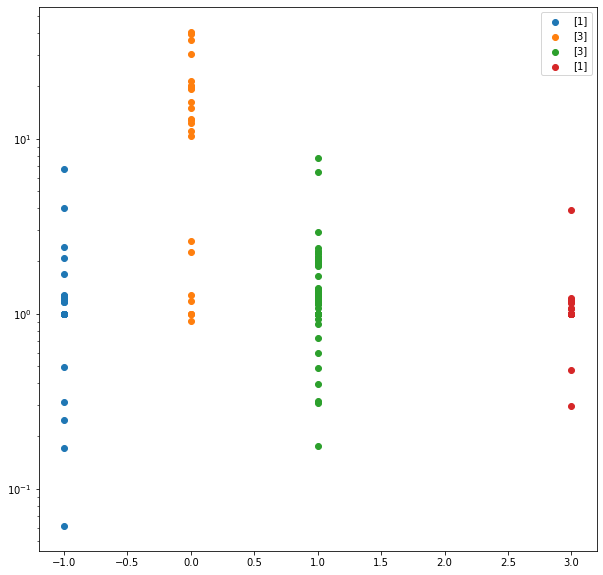

In [10]:
means = []
plt.figure(figsize=(10,10))
plt.clf()
for x in np.unique(label).astype(np.int32):
    idx = np.argwhere(label[:,0]==x).astype(np.int32)
    mcur = curves[idx]
    plt.scatter(np.full(len(idx),  x),  (curves[idx,2]) / (curves[idx,4]), label=label[x])
    means.append(np.nanmean((curves[idx,2]) / (curves[idx,4])))
plt.legend()
plt.yscale('log')
#plt.ylim(0,1)

In [11]:
print(means)

[1.306813332777054, 14.788275181989402, 1.4814607824304462, 1.1388254370526254]


In [12]:
1=1
curves = []
label = []
ids = []
for i, f in enumerate(files[:38]):
    print(i)
    x, y, c = loadABF(f)
    d_name = os.path.dirname(f)
    base = os.path.basename(f)
    ids.append(base)
    label.append(d_name)
    dfs = []
    temp_curves
    plt.clf()
    for sweepX, sweepY, sweepC in zip(x,y,c):
        spikext = feature_extractor.SpikeFeatureExtractor(filter=0)
        res = spikext.process(sweepX, sweepY, sweepC)
        dfs.append(res)
        if res.empty==False:
            if len(non_empty_df) > 1:
                sweep_to_use = non_empty_df[1]
            else:
                sweep_to_use = non_empty_df[-1]
    non_empty_df = np.nonzero(np.invert([df.empty for df in dfs]))[0]
    
    
    try:
        spike_time = dfs[sweep_to_use]['threshold_index'].to_numpy()[0]
        curve = exp_growth_factor(x[sweep_to_use,:], y[sweep_to_use,:], c[sweep_to_use,:], spike_time)
        curves.append(curve)
    except:
        curves.append([np.nan, np.nan, np.nan, np.nan, np.nan])
    plt.show()
print(non_empty_df)

SyntaxError: can't assign to literal (<ipython-input-12-b07f0ea16760>, line 1)